# Maze Experiments in Curriculum Learning in a Single Environment
## Still the same principle, just saving memory
## Give the Distance To Teacher
-------------------------------


Salkey, Jayson

26/07/2018

-----------------------------------


# Setup

### Import Useful Libraries

In [281]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
from collections import namedtuple
from scipy import stats

### Set options

In [282]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=1)

In [283]:
class Maze(object):
    def __init__(self, width, height, complexity, density, num_goals, goal):
        self._maze, self._maze_clean, self._goal_locations = self.maze(width, height, complexity, density, num_goals, goal)
        
    def maze(self, width=81, height=51, complexity=.75, density=.75, num_goals=1, goal=1):
        goal_locations = []
        
        # Only odd shapes
        shape = ((height // 2) * 2 + 1, (width // 2) * 2 + 1)
        # Adjust complexity and density relative to maze size
        complexity = int(complexity * (5 * (shape[0] + shape[1]))) # number of components
        density    = int(density * ((shape[0] // 2) * (shape[1] // 2))) # size of components
        # Build actual maze
        Z = np.zeros(shape)
        # Fill borders
        Z[0, :] = Z[-1, :] = 1
        Z[:, 0] = Z[:, -1] = 1
        # Make aisles
        for i in range(density):
            x, y = np.random.randint(0, (shape[1] // 2)+1) * 2, np.random.randint(0, (shape[0] // 2)+1) * 2 # pick a random position
            Z[y, x] = 1
            for j in range(complexity):
                neighbours = []
                if x > 1:             neighbours.append((y, x - 2))
                if x < shape[1] - 2:  neighbours.append((y, x + 2))
                if y > 1:             neighbours.append((y - 2, x))
                if y < shape[0] - 2:  neighbours.append((y + 2, x))
                if len(neighbours):
                    y_,x_ = neighbours[np.random.randint(0, len(neighbours))]
                    if Z[y_, x_] == 0:
                        Z[y_, x_] = 1
                        Z[y_ + (y - y_) // 2, x_ + (x - x_) // 2] = 1
                        x, y = x_, y_
        Z[Z == 1] = -1
        Y = np.copy(Z)
        for x in range(0, num_goals):
            idx = np.random.randint(len(np.where(Z == 0)[0]))
            Z[np.where(Z == 0)[0][idx],np.where(Z == 0)[1][idx]] = goal
        for e in zip(np.where(Z == goal)[0],np.where(Z == goal)[1]):
            goal_locations.append((e[0],e[1],goal))
        return Z,Y,goal_locations


### A hallway world

In [284]:
class Hallway(object):

  def __init__(self, goal_loc, tabular=True, vision_size=1, discount=0.98, noisy=False, layout=None):
    
    self._wall = -1
    self._layout = layout
    
    # row, col format
    self._start_state = (1, 1)
    self._state = self._start_state
    self._number_of_states = np.prod(np.shape(self._layout))
    self._noisy = noisy
    self._tabular = tabular
    self._vision_size = vision_size
    self._discount = discount
    
    self._goals = set()
    self._goal_loc = []
    self._distances_to_goal = []
    
    self._dist = {}
    for r,c in zip(np.where(self._layout != self._wall)[0],np.where(self._layout != self._wall)[1]):
      self._dist[(r, c)] = self.dijkstra(r, c)
      
    for e in goal_loc:
      self._layout[e[0],e[1]] = e[2]
      self._goal_loc.append((e[0],e[1]))
      self._goals.add(e[2])
      self._distances_to_goal.append(self.minDistanceTwoPoints(self._start_state[0], self._start_state[1], e[0],e[1]))
    
    
  def resetState(self):
    self._state = self._start_state
  
  def distanceLeft(self, teacher_action):
    goal_y = self._goal_loc[teacher_action][0]
    goal_x = self._goal_loc[teacher_action][1]
    return self.minDistanceTwoPoints(self._state[0], self._state[1], goal_y, goal_x)
  
  def distanceToGoal(self, teacher_action):
    return np.prod(self._layout.shape)
  
  def dijkstra(self, cy, cx):
    dist = {}
    prev = {}
    Q = set()
    
    for r,c in zip(np.where(self._layout != self._wall)[0],np.where(self._layout != self._wall)[1]):
      dist[(r,c)] = np.inf
      prev[(r,c)] = None
      Q.add((r,c))
    
    dist[(cy,cx)] = 0.
    
    while len(Q) != 0:
      ud = np.inf
      u = None
      for e in Q:
        if dist[e] < ud:
          ud = dist[e]
          u = e
      Q.remove(u)
      
      neighbors_u = []
      if u[0]+1 < self._layout.shape[0] and self._layout[u[0]+1, u[1]] != self._wall and (u[0]+1, u[1]) in Q:
        neighbors_u.append((u[0]+1, u[1]))
      
      if u[0]-1 > -1 and self._layout[u[0]-1, u[1]] != self._wall and (u[0]-1, u[1]) in Q:
        neighbors_u.append((u[0]-1, u[1]))
      
      if u[1]+1 < self._layout.shape[1] and self._layout[u[0], u[1]+1] != self._wall and (u[0], u[1]+1) in Q:
        neighbors_u.append((u[0], u[1]+1))
      
      if u[1]-1 > -1 and self._layout[u[0], u[1]-1] != self._wall and (u[0], u[1]-1) in Q:
        neighbors_u.append((u[0], u[1]-1))
        
      for neighbor in neighbors_u:
        alt = dist[u] + 1.
        if alt < dist[neighbor]:
          dist[neighbor] = alt
          prev[neighbor] = u
    
    return dist
  
  def minDistanceTwoPoints(self, cy, cx, dy, dx):
    return self._dist[(cy,cx)][(dy,dx)]
    
  def handleDoor(self):
    pass
  
  @property
  def number_of_states(self):
    return self._number_of_states
    
  def plot_grid(self, title=None):
    plt.figure(figsize=(4, 4))
    plt.imshow(self._layout != self._wall, interpolation="nearest", cmap='pink')
    ax = plt.gca()
    ax.grid(0)
    plt.xticks([])
    plt.yticks([])
    if title != None:
      plt.title(title)
    else:
      plt.title("The Grid")
    plt.text(self._start_state[1], self._start_state[0], r"$\mathbf{S}$", ha='center', va='center')
    for e in self._goals:
      if e > 0:
        y = np.where(self._layout==e)[0]
        x = np.where(self._layout==e)[1]
        for i in range(y.shape[0]): 
          plt.text(x[i], y[i], r"$\mathbf{G}$", ha='center', va='center')  
    h, w = self._layout.shape
    for y in range(h-1):
      plt.plot([-0.5, w-0.5], [y+0.5, y+0.5], '-k', lw=2)
    for x in range(w-1):
      plt.plot([x+0.5, x+0.5], [-0.5, h-0.5], '-k', lw=2)

  def get_obs(self):
    y, x = self._state
    return self.get_obs_at(x, y)

  def get_obs_at(self, x, y):
    if self._tabular:
      return y*self._layout.shape[1] + x
    else:
      v = self._vision_size
      #location = np.clip(-self._layout[y-v:y+v+1,x-v:x+v+1], 0, 1)
      #location = np.clip(-self._layout[y-v:y+v+1,x-v:x+v+1], -1, 2)
      location = self._layout[y-v:y+v+1,x-v:x+v+1]
      return location

  def step(self, action, teacher_action, agent_inventory):
    item = None
    goal_y = self._goal_loc[teacher_action][0]
    goal_x = self._goal_loc[teacher_action][1]
    y, x = self._state
        
    if action == 0:  # up
      new_state = (y - 1, x)
    elif action == 1:  # right
      new_state = (y, x + 1)
    elif action == 2:  # down
      new_state = (y + 1, x)
    elif action == 3:  # left
      new_state = (y, x - 1)
    else:
      raise ValueError("Invalid action: {} is not 0, 1, 2, or 3.".format(action))

    new_y, new_x = new_state
    discount = self._discount
    if self._layout[new_y, new_x] == self._wall:  # a wall
      reward = -1
      new_state = (y, x)
    elif self._layout[new_y, new_x] > 0 and (new_y, new_x) == (goal_y, goal_x) : # a goal
      reward = self._layout[new_y, new_x]
      discount = 0.
      new_state = self._start_state
    else:
      minDistanceStart = self.minDistanceTwoPoints(self._start_state[0], self._start_state[1], goal_y, goal_x)
      distToGoal = self.minDistanceTwoPoints(new_y, new_x, goal_y, goal_x)
      distToGoal = float(distToGoal)
      minDistanceStart = float(minDistanceStart)
      #reward = self._layout[goal_y,goal_x]*np.exp(-distToGoal/minDistanceStart) - self._layout[goal_y,goal_x]
      reward = np.exp(-distToGoal) - 1.
    if self._noisy:
      width = self._layout.shape[1]
      reward += 2*np.random.normal(0, width - new_x + new_y)
    
    self._state = new_state

    return reward, discount, self.get_obs(), item
     

### The Hallway(s)

('Task: 0', (3, 15, 1))
('Task: 1', (4, 11, 1))
('Task: 2', (6, 15, 1))
('Task: 3', (10, 3, 1))
('Task: 4', (13, 15, 1))


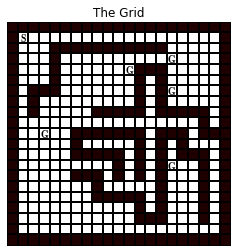

In [285]:
maze = Maze(20,20,0.1,0.05,5,1)  
vision_size = 1
tabular_grid = False

tasks = []
tasks.append(Hallway(goal_loc = maze._goal_locations, tabular=tabular_grid, vision_size=vision_size, discount=0.98, layout=np.copy(maze._maze_clean)))

for idx, goal_loc in enumerate(maze._goal_locations):
  print('Task: '+str(idx), goal_loc)

for task in tasks:
    task.plot_grid()


## Implement agents


In [286]:
class GeneralQ(object):

  def __init__(self, number_of_states, number_of_actions, initial_state, target_policy, behaviour_policy, double, num_offline_updates=30, step_size=0.1):
    self._q = np.zeros((number_of_states, number_of_actions))
    self._replayBuffer_A = []
    if double:
      self._q2 = np.zeros((number_of_states, number_of_actions))
      self._replayBuffer_B = []
    self._s = initial_state
    self._initial_state = initial_state
    self._number_of_actions = number_of_actions
    self._step_size = step_size
    self._behaviour_policy = behaviour_policy
    self._target_policy = target_policy
    self._double = double
    self._num_offline_updates = num_offline_updates
    self._last_action = 0
    self._inventory = set()
  
  def resetReplayBuffer(self):
    self._replayBuffer_A = []
    if self._double:
      self._replayBuffer_B = []
      
  @property
  def q_values(self):
    if self._double:
      return (self._q + self._q2)/2
    else:
      return self._q
    
  def resetState(self):
    self._s = self._initial_state 

  def step(self, r, g, s, item, train):
    td = None
    
    if item != None:
      self._inventory.add(item)
      
    if self._double:
      next_action = self._behaviour_policy(self.q_values[s,:], train)
      if np.random.random() <= 0.5:
        expectation = np.sum(self._target_policy(self._q[s,:], next_action) * self._q2[s,:])
        td = self._step_size*(r + g*expectation - self._q[self._s,self._last_action])
        if train == True:
          self._q[self._s,self._last_action] += self._step_size*(r + g*expectation - self._q[self._s,self._last_action])
          #self._q[self._s,self._last_action] += self._step_size*(r + g*self._q2[s,np.argmax(target_policy(self._q[s,:], next_action))] - self._q[self._s,self._last_action])
          self._replayBuffer_A.append([self._s,self._last_action,r,g,s,next_action])
          for _ in range(self._num_offline_updates):
            replay = self._replayBuffer_A[np.random.randint(len(self._replayBuffer_A))]
            expectation = np.sum(self._target_policy(self._q[replay[4],:], replay[5]) * self._q2[replay[4],:])
            self._q[replay[0],replay[1]] += self._step_size*(replay[2] + replay[3] * expectation - self._q[replay[0],replay[1]])

      else:
        expectation = np.sum(self._target_policy(self._q2[s,:], next_action) * self._q[s,:])
        td = self._step_size*(r + g*expectation - self._q2[self._s,self._last_action])
        if train == True:
          self._q2[self._s,self._last_action] += self._step_size*(r + g*expectation - self._q2[self._s,self._last_action])   
          #self._q2[self._s,self._last_action] += self._step_size*(r + g*self._q[s,np.argmax(target_policy(self._q2[s,:], next_action))] - self._q2[self._s,self._last_action])    
          self._replayBuffer_B.append([self._s,self._last_action,r,g,s,next_action])
          for _ in range(self._num_offline_updates):
            replay = self._replayBuffer_B[np.random.randint(len(self._replayBuffer_B))]
            expectation = np.sum(self._target_policy(self._q[replay[4],:], replay[5]) * self._q2[replay[4],:])
            self._q[replay[0],replay[1]] += self._step_size*(replay[2] + replay[3] * expectation - self._q[replay[0],replay[1]])

      self._s = s
      self._last_action = next_action
      return self._last_action, self._inventory, td
    else:
      next_action = self._behaviour_policy(self._q[s,:], train)
      # This is expected sarsa, but still functions as expected.
      expectation = np.sum(self._target_policy(self._q[s,:], next_action) * self._q[s,:])
      td = self._step_size*(r + g*expectation - self._q[self._s,self._last_action])
      if train == True:
        self._q[self._s,self._last_action] += self._step_size*(r + g*expectation - self._q[self._s,self._last_action])
        #self._q[self._s,self._last_action] += self._step_size*(r + g*self._q[s,np.argmax(target_policy(self._q[s,:], next_action))] - self._q[self._s,self._last_action])
        self._replayBuffer_A.append([self._s,self._last_action,r,g,s,next_action])
        for _ in range(self._num_offline_updates):
          replay = self._replayBuffer_A[np.random.randint(len(self._replayBuffer_A))]
          expectation = np.sum(self._target_policy(self._q[replay[4],:], replay[5]) * self._q2[replay[4],:])
          self._q[replay[0],replay[1]] += self._step_size*(replay[2] + replay[3] * expectation - self._q[replay[0],replay[1]])

      self._s = s
      self._last_action = next_action
      #print(self._inventory)
      return self._last_action, self._inventory, td
    

In [287]:
def Q_target_policy(q, a):
  return np.eye(len(q))[np.argmax(q)]

def SARSA_target_policy(q, a):
  return np.eye(len(q))[a]

def gen_behaviour_policy(q, train):
  #return epsilon_greedy(q, 0.1) if train == True else np.random.choice(np.where(np.max(q) == q)[0])
  return epsilon_greedy(q, 0.1) if train == True else epsilon_greedy(q, 0.01)

An agent that uses **Neural-Sarsa/DQN** to learn action values.  The agent should expect a nxn input which it should flatten into a vector, and then pass through a multi-layer perceptron with a single hidden layer with 100 hidden nodes and ReLU activations.  Each weight layer should also have a bias.  Initialize all weights uniformly randomly in $[-0.05, 0.05]$.

```
NeuralSarsa(number_of_features=(2*vision_size + 1)**2,
            number_of_hidden=100,
            number_of_actions=4,
            initial_state=grid.get_obs(),
            step_size=0.01)
            
DQN(number_of_features=(2*vision_size + 1)**2,
            number_of_hidden=100,
            number_of_actions=4,
            initial_state=grid.get_obs(),
            step_size=0.01)
```

The number `vision_size` will be either 1 or 2 below.  The input vector will be of size $(2v + 1)^2$, which will correspond to a square local view of the grid, centered on the agent, and of size $(2v + 1) \times (2v + 1)$ (so either 3x3 or 5x5).

In [288]:
class NEURAL_CONTROLLER_DRIVER(object):
  
  # Target Network is the same, as C-step is just C=1
  
  def __init__(self, number_of_features_controller,
                number_of_features_driver,
                number_of_hidden_controller,
                number_of_hidden_driver,
                number_of_actions_controller,
                number_of_actions_driver,
                initial_state_controller,
                initial_state_driver, 
                rl_alg_controller='DQN',
                rl_alg_driver='DQN', 
                num_offline_updates_controller=25, 
                num_offline_updates_driver=25,
                step_size_controller=0.01,
                step_size_driver=0.01): 
    # HMMM?
    tf.reset_default_graph()

    self._prev_action_driver = 0
    self._step_driver = step_size_driver
    self._num_features_driver = number_of_features_driver
    self._num_action_driver = number_of_actions_driver
    self._num_hidden_driver = number_of_hidden_driver
    self._initial_state_driver = initial_state_driver
    self._s_driver = initial_state_driver
    self._s_driver = np.reshape(self._s_driver, (1,-1))
    self._times_trained_driver = 0
    self._inventory = set()
    self._replayBuffer_driver = []
    self._num_offline_updates_driver = num_offline_updates_driver
    self._rl_alg_driver = rl_alg_driver
    self._eps_driver = 1.0


    
    self._prev_action_controller = 0
    self._step_controller = step_size_controller
    self._num_features_controller = number_of_features_controller
    self._num_action_controller = number_of_actions_controller
    self._num_hidden_controller = number_of_hidden_controller
    self._initial_state_controller = initial_state_controller
    self._s_controller = initial_state_controller
    self._s_controller = np.reshape(self._s_controller, (1,-1))
    self._times_trained_controller = 0
    self._replayBuffer_controller = []
    self._num_offline_updates_controller = num_offline_updates_controller
    self._rl_alg_controller = rl_alg_controller
    self.name = 'HYPER '+self._rl_alg_controller
    self._eps_controller = 1.0
    
    # ?????????? should it be the number of tasks
    self._probs_controller = np.ones((1, self._num_features_controller))/(self._num_features_controller*1.)
    
    
    self._times_used = 0.
    
    self.handleTF()
  
  def reset(self):
    tf.reset_default_graph()
    self.handleTF()
    self.resetState_controller()
    self.resetReplayBuffer_controller()
    self._probs_controller = np.ones((1, self._num_features_controller))/(self._num_features_controller*1.)
    self._times_trained_controller = 0
    self._prev_action_controller = 0
    self._eps_controller = 1.0
    self.resetReplayBuffer()
    self.resetState()
    self._times_trained_driver = 0
    self._prev_action_driver = 0
    self._eps_driver = 1.0
    self._inventory = set()
    self._times_used = 0

  def resetReplayBuffer_controller(self):
    self._replayBuffer_controller = []
    
  def resetState_controller(self):
    self._s_controller = self._initial_state_controller 
    self._s_controller = np.reshape(self._s_controller, (1,-1))
    
  def handleTF(self):
    self._sess = tf.Session()
    #tf.reset_default_graph()
    self.rewTensor_controller = tf.placeholder(tf.float64)
    self.disTensor_controller = tf.placeholder(tf.float64)
    self.nqTensor_controller = tf.placeholder(tf.float64)
    self.actionTensor_controller = tf.placeholder(tf.int32)
    self.stateTensor_controller = tf.placeholder(tf.float64, shape=(1,self._num_features_controller))
    self._dense_1_controller = tf.layers.dense(self.stateTensor_controller,
                                    self._num_hidden_controller, activation=tf.nn.tanh,
                                    kernel_initializer=tf.random_uniform_initializer(-0.05, 0.05),
                                    bias_initializer=tf.random_uniform_initializer(-0.05, 0.05))
    self._dense_2_controller = tf.layers.dense(self._dense_1_controller,
                                    self._num_action_controller, activation=None,
                                    kernel_initializer=tf.random_uniform_initializer(-0.05, 0.05),
                                    bias_initializer=tf.random_uniform_initializer(-0.05, 0.05))
    self._q_controller = tf.reshape(self._dense_2_controller, (self._num_action_controller,))    
    self._softmx_controller = tf.nn.softmax(self._q_controller)
    self._cost_controller = tf.losses.mean_squared_error(self.rewTensor_controller + self.disTensor_controller*self.nqTensor_controller, self._q_controller[self.actionTensor_controller])
    self._opt_controller = tf.train.RMSPropOptimizer(self._step_controller).minimize(self._cost_controller) 
    

    self.rewTensor_driver = tf.placeholder(tf.float64)
    self.disTensor_driver = tf.placeholder(tf.float64)
    self.nqTensor_driver = tf.placeholder(tf.float64)
    self.actionTensor_driver = tf.placeholder(tf.int32)
    self.stateTensor_driver = tf.placeholder(tf.float64, shape=(1,self._num_features_driver))
    self._dense_1_driver = tf.layers.dense(self.stateTensor_driver,
                                    self._num_hidden_driver, activation=tf.nn.tanh,
                                    kernel_initializer=tf.random_uniform_initializer(-0.05, 0.05),
                                    bias_initializer=tf.random_uniform_initializer(-0.05, 0.05))
    self._dense_2_driver = tf.layers.dense(self._dense_1_driver,
                                    self._num_action_driver, activation=None,
                                    kernel_initializer=tf.random_uniform_initializer(-0.05, 0.05),
                                    bias_initializer=tf.random_uniform_initializer(-0.05, 0.05))
    self._q_driver = tf.reshape(self._dense_2_driver, (self._num_action_driver,))    
    self._cost_driver = tf.losses.mean_squared_error(self.rewTensor_driver+ self.disTensor_driver*self.nqTensor_driver, self._q_driver[self.actionTensor_driver])
    self._opt_driver = tf.train.RMSPropOptimizer(self._step_driver).minimize(self._cost_driver)


    # HMMM?
    self._sess.run(tf.global_variables_initializer())

  def _target_policy_controller(self, q, a):
    return np.eye(len(q))[a]
 
  def _behaviour_policy_controller(self, q):    
    return epsilon_greedy(q, self._eps_controller)# if train == True else np.random.choice(np.where(np.max(q) == q)[0])

  def getProbs(self):
    # softmax
    return self._probs_controller

  def q_controller(self, obs):
    #print [n.name for n in tf.get_default_graph().as_graph_def().node]
    obs = np.reshape(obs,(1,-1))
    #print obs
    t, probs = self._sess.run([self._q_controller, self._softmx_controller], {self.stateTensor_controller: obs})
    return t, probs
  
  def step_controller(self, r, g, s):
    self._times_used += 1
    #print self._times_used
    qvs, probs = self.q_controller(s)
    q_nxtState = np.reshape(qvs, (-1,))
    self._probs_controller = probs
    next_action = self._behaviour_policy_controller(q_nxtState)
    
    if r != None:
      if self._rl_alg_controller == 'NEURALSARSA':
        target = self._target_policy_controller(q_nxtState, next_action)
        target = np.random.choice(np.where(np.max(target) == target)[0])
        vob = q_nxtState[target]
        #print vob
        self._sess.run(self._opt_controller,{
            self.nqTensor_controller: vob,
            self.rewTensor_controller: r,
            self.disTensor_controller: g,
            self.actionTensor_controller: self._prev_action_controller,
            self.stateTensor_controller: self._s_controller})
        self._replayBuffer_controller.append([self._s_controller, self._prev_action_controller, r, g, vob])
        for _ in range(self._num_offline_updates_controller):
          replay = self._replayBuffer_controller[np.random.randint(len(self._replayBuffer_controller))]
          self._sess.run(self._opt_controller,{
              self.nqTensor_controller: replay[4],
              self.rewTensor_controller: replay[2],
              self.disTensor_controller: replay[3],
              self.actionTensor_controller: replay[1],
              self.stateTensor_controller: replay[0]})
      elif self._rl_alg_controller == 'DQN':
        # This function should return an action
        # Optimiser
        vob = np.max(q_nxtState)
        self._sess.run(self._opt_controller,{
            self.nqTensor_controller: vob,
            self.rewTensor_controller: r,
            self.disTensor_controller: g,
            self.actionTensor_controller: self._prev_action_controller,
            self.stateTensor_controller: self._s_controller})
        self._replayBuffer_controller.append([self._s_controller, self._prev_action_controller, r, g, vob])
        for _ in range(self._num_offline_updates_controller):
          replay = self._replayBuffer_controller[np.random.randint(len(self._replayBuffer_controller))]
          self._sess.run(self._opt_controller,{
              self.nqTensor_controller: replay[4],
              self.rewTensor_controller: replay[2],
              self.disTensor_controller: replay[3],
              self.actionTensor_controller: replay[1],
              self.stateTensor_controller: replay[0]})

    self._s_controller = np.reshape(s, (1,-1))
    self._prev_action_controller = next_action
    
    return next_action

  def reset_controller(self):
    tf.reset_default_graph()
    self.handleTF()
    self.resetState_controller()
    self.resetReplayBuffer_controller()
    self._probs_controller = np.ones((1, self._num_features_controller))/(self._num_features_controller*1.)
    self._times_trained_controller = 0
    self._prev_action_controller = 0



    # resetReplayBuffer_driver
  def resetReplayBuffer(self):
    self._replayBuffer_driver = []
    
    # resetState_driver
  def resetState(self):
    self._s_driver = self._initial_state_driver 
    self._s_driver = np.reshape(self._s_driver, (1,-1))


  def _target_policy_driver(self, q, a):
    return np.eye(len(q))[a]
 
  def _behaviour_policy_driver(self, q, train):
    #return epsilon_greedy(q, 0.1) if train == True else np.random.choice(np.where(np.max(q) == q)[0])
    return epsilon_greedy(q, self._eps_driver) if train == True else epsilon_greedy(q, 0.01)

  def q_driver(self, obs):
    #print [n.name for n in tf.get_default_graph().as_graph_def().node]
    obs = np.reshape(obs,(1,-1))
    #print obs
    t = self._sess.run(self._q_driver, {self.stateTensor_driver: obs})
    return t
  
  # step_driver
  def step(self, r, g, s, item, train, steps_taken):
    cost = None
    
    if item != None:
      self._inventory.add(item)
    
    # This function should return an action
    q_nxtState = np.reshape(self.q_driver(s), (-1,))
    next_action = self._behaviour_policy_driver(q_nxtState, train)
    

    if self._rl_alg_driver == 'NEURALSARSA':
      target = self._target_policy_driver(q_nxtState, next_action)
      target = np.random.choice(np.where(np.max(target) == target)[0])
      
      # Optimiser
      vob = q_nxtState[target]
#       cost = self._sess.run(self._cost_driver,{
#           self.nqTensor_driver: vob,
#           self.rewTensor_driver: r,
#           self.disTensor_driver: g,
#           self.actionTensor_driver: self._prev_action_driver,
#           self.stateTensor_driver: self._s_driver})
      if train == True:
        self._sess.run(self._opt_driver,{
            self.nqTensor_driver: vob,
            self.rewTensor_driver: r,
            self.disTensor_driver: g,
            self.actionTensor_driver: self._prev_action_driver,
            self.stateTensor_driver: self._s_driver})
        self._replayBuffer_driver.append([self._s_driver, self._prev_action_driver, r, g, vob])
        for _ in range(self._num_offline_updates_driver):
          replay = self._replayBuffer_driver[np.random.randint(len(self._replayBuffer_driver))]
          self._sess.run(self._opt_driver,{
              self.nqTensor_driver: replay[4],
              self.rewTensor_driver: replay[2],
              self.disTensor_driver: replay[3],
              self.actionTensor_driver: replay[1],
              self.stateTensor_driver: replay[0]})
    elif self._rl_alg_driver == 'DQN':
      vob = np.max(q_nxtState)
#       cost = self._sess.run(self._cost_driver,{
#               self.nqTensor_driver: vob,
#               self.rewTensor_driver: r,
#               self.disTensor_driver: g,
#               self.actionTensor_driver: self._prev_action_driver,
#               self.stateTensor_driver: self._s_driver})
      if train == True:
        self._sess.run(self._opt_driver,{
            self.nqTensor_driver: vob,
            self.rewTensor_driver: r,
            self.disTensor_driver: g,
            self.actionTensor_driver: self._prev_action_driver,
            self.stateTensor_driver: self._s_driver})
        self._replayBuffer_driver.append([self._s_driver, self._prev_action_driver, r, g, vob])
        for _ in range(self._num_offline_updates_driver):
          replay = self._replayBuffer_driver[np.random.randint(len(self._replayBuffer_driver))]
          self._sess.run(self._opt_driver,{
              self.nqTensor_driver: replay[4],
              self.rewTensor_driver: replay[2],
              self.disTensor_driver: replay[3],
              self.actionTensor_driver: replay[1],
              self.stateTensor_driver: replay[0]})

    
        
    self._s_driver = np.reshape(s, (1,-1))
    self._prev_action_driver = next_action
    return next_action, self._inventory, cost

## Agent 0: Random

In [289]:
class Random(object):
  """A random agent.
  
  This agent returns an action between 0 and 'number_of_arms', 
  uniformly at random. The 'previous_action' argument of 'step'
  is ignored.
  """

  def __init__(self, number_of_arms):
    self._number_of_arms = number_of_arms
    self.name = 'random'
    self.reset()

  def step(self, previous_action, reward):
    return np.random.randint(self._number_of_arms)
  
  def getProbs(self):
    return np.ones((self._number_of_arms))/self._number_of_arms
  
  def reset(self):
    pass

## Agent 1: REINFORCE

In [290]:
class REINFORCE(object):
 
  def __init__(self, number_of_arms, step_size=0.1, baseline=False):
    self._number_of_arms = number_of_arms
    self._lr = step_size
    self.name = 'reinforce, baseline: {}'.format(baseline)
    self._baseline = baseline
    self.action_values = np.zeros((2,self._number_of_arms))
    self.action_preferences = np.zeros((1,self._number_of_arms))
    self.total_reward = 0;
    self.number_rewards = 0.
    self.reset()
  
  def step(self, previous_action, reward):
    if previous_action != None:
      self.number_rewards += 1.
      self.total_reward += reward
      self.action_values[0,previous_action] += reward
      self.action_values[1,previous_action] += 1.
      self.updatePreferences(previous_action, reward)
#    unvisited = np.where(self.action_values[1,:] == 0.)
#     if unvisited[0].size > 0:
#       return unvisited[0][0]
#     else:
#       return np.random.choice(np.arange(0,self._number_of_arms),p=self.softmax())
    return np.random.choice(np.arange(0,self._number_of_arms),p=self.softmax())
    
  def reset(self):
    self.action_values = np.zeros((2,self._number_of_arms))
    self.action_preferences = np.zeros((1,self._number_of_arms))
    self.number_rewards = 0.
    self.total_reward = 0.
  
  def updatePreferences(self, previous_action, reward):
    if not self._baseline: 
      self.action_preferences[0,previous_action]+=self._lr*reward*(1-self.softmax()[previous_action])
      for i in range(0,self._number_of_arms):
        if i != previous_action:
          self.action_preferences[0,i]-=self._lr*reward*self.softmax()[i]
    else:
      self.action_preferences[0,previous_action]+=self._lr*(reward - self.total_reward/self.number_rewards)*(1-self.softmax()[previous_action])
      for i in range(0,self._number_of_arms):
        if i != previous_action:
          self.action_preferences[0,i]-=self._lr*(reward - self.total_reward/self.number_rewards)*self.softmax()[i]
    
  def softmax(self):
    q = np.sum(np.exp(self.action_preferences),axis=1)
    t = np.exp(self.action_preferences)/q
    return t.flatten()
  
  def getProbs(self):
    return self.softmax()

## Agent 2: EXP3

In [291]:
class EXP3(object):

  def __init__(self, number_of_arms, gamma):
    self._number_of_arms = number_of_arms
    self.name = 'exp3 Gamma: ' + str(gamma)
    
    self.action_values = np.zeros((2,self._number_of_arms))
    
    self.gamma = gamma
    self.weights = np.ones((1,self._number_of_arms))
    
    self.time = 0.
    self.reset()
  
  def step(self, previous_action, reward):
    if previous_action != None:
      xhat = np.zeros((1, self._number_of_arms))
      xhat[0,previous_action] = reward/self.action_values[0,previous_action]
      self.weights = self.weights*np.exp(self.gamma*xhat/self._number_of_arms)
      self.action_values[1,previous_action] += 1.
    self.action_values[0,:] = (1-self.gamma)*(self.weights)/(np.sum(self.weights)) + self.gamma/self._number_of_arms
    action = np.random.choice(self._number_of_arms, p=self.action_values[0,:])
    self.time += 1.
    unvisited = np.where(self.action_values[1,:] == 0.)
    return unvisited[0][0] if unvisited[0].size > 0 else action
  
  def getProbs(self):
    return self.action_values[0,:]
  
  def reset(self):
    self.action_values = np.zeros((2, self._number_of_arms))
    self.weights = np.ones((1, self._number_of_arms))
    self.time = 0
    return

## Agent 7: Task Selection via RL

In [292]:
class NS_DQN(object):
  
  # Target Network is the same, as C-step is just C=1
  
  def __init__(self, teacher_student, number_of_features, number_of_hidden, number_of_actions, initial_state, rl_alg='DQN', num_offline_updates=25, step_size=0.01):
    
    tf.reset_default_graph()
    self._prev_action = 0
    self._step = step_size
    self._num_features = number_of_features
    self._num_action = number_of_actions
    self._num_hidden = number_of_hidden
    self._initial_state = initial_state
    self._s = initial_state
    self._s = np.reshape(self._s, (1,-1))
    self._times_trained = 0
    self._replayBuffer = []
    self._num_offline_updates = num_offline_updates
    self._rl_alg = rl_alg
    self._teacher_student = teacher_student
    self._probs = np.ones((1, self._num_action))/(self._num_action*1.)
    self._inventory = set()
    
    if self._teacher_student == True:
      self.name = 'HYPER '+self._rl_alg
    else:
      self.name = self._rl_alg
    
    self.handleTF()
  
  def resetReplayBuffer(self):
    self._replayBuffer = []
    
  def resetState(self):
    self._s = self._initial_state 
    self._s = np.reshape(self._s, (1,-1))
    
  def handleTF(self):
    self._sess = tf.Session()
    #tf.reset_default_graph()
    self.rewTensor = tf.placeholder(tf.float64)
    self.disTensor = tf.placeholder(tf.float64)
    self.nqTensor = tf.placeholder(tf.float64)
    self.actionTensor = tf.placeholder(tf.int32)
    self.stateTensor = tf.placeholder(tf.float64, shape=(1,self._num_features))
    self._dense_1 = tf.layers.dense(self.stateTensor,
                                    self._num_hidden, activation=tf.nn.tanh,
                                    kernel_initializer=tf.random_uniform_initializer(-0.05, 0.05),
                                    bias_initializer=tf.random_uniform_initializer(-0.05, 0.05))
    self._dense_2 = tf.layers.dense(self._dense_1,
                                    self._num_action, activation=None,
                                    kernel_initializer=tf.random_uniform_initializer(-0.05, 0.05),
                                    bias_initializer=tf.random_uniform_initializer(-0.05, 0.05))
    self._q = tf.reshape(self._dense_2, (self._num_action,))    
    self._softmx = tf.nn.softmax(self._q)
    self._cost = tf.losses.mean_squared_error(self.rewTensor + self.disTensor*self.nqTensor, self._q[self.actionTensor])
    self._opt = tf.train.RMSPropOptimizer(self._step).minimize(self._cost) 
    # HMMM?
    self._sess.run(tf.global_variables_initializer())

  def _target_policy(self, q, a):
    return np.eye(len(q))[a]
 
  def _behaviour_policy(self, q, train):
    if self._teacher_student == True:   
      return epsilon_greedy(q, 0.1)#if train == True else np.random.choice(np.where(np.max(q) == q)[0])
    else:
      return epsilon_greedy(q, 0.1) if train == True else epsilon_greedy(q, 0.01)
  
  def getProbs(self):
    # softmax
    return self._probs
  
  def q_noProbs(self, obs):
    obs = np.reshape(obs,(1,-1))
    t = self._sess.run(self._q, {self.stateTensor: obs})
    return t
  
  def q(self, obs):
    obs = np.reshape(obs,(1,-1))
    t, probs = self._sess.run([self._q, self._softmx], {self.stateTensor: obs})
    return t, probs
  
  def step(self, r, g, s, item=None, train=True, steps_taken=None):
    cost = None

    if item != None:
      self._inventory.add(item)

    qvs, probs = self.q(s)
    q_nxtState = np.reshape(qvs, (-1,))
    self._probs = probs
    next_action = self._behaviour_policy(q_nxtState, train)
    
    if r != None:
      if self._rl_alg == 'NEURALSARSA':
        target = self._target_policy(q_nxtState, next_action)
        target = np.random.choice(np.where(np.max(target) == target)[0])
        vob = q_nxtState[target]

        if train == True:
          self._sess.run(self._opt,{
              self.nqTensor: vob,
              self.rewTensor: r,
              self.disTensor: g,
              self.actionTensor: self._prev_action,
              self.stateTensor: self._s})
          self._replayBuffer.append([self._s, self._prev_action, r, g, vob])
          for _ in range(self._num_offline_updates):
            replay = self._replayBuffer[np.random.randint(len(self._replayBuffer))]
            self._sess.run(self._opt,{
                self.nqTensor: replay[4],
                self.rewTensor: replay[2],
                self.disTensor: replay[3],
                self.actionTensor: replay[1],
                self.stateTensor: replay[0]})
      elif self._rl_alg == 'DQN':
        vob = np.max(q_nxtState)

        if train == True:
          self._sess.run(self._opt,{
              self.nqTensor: vob,
              self.rewTensor: r,
              self.disTensor: g,
              self.actionTensor: self._prev_action,
              self.stateTensor: self._s})
          self._replayBuffer.append([self._s, self._prev_action, r, g, vob])
          for _ in range(self._num_offline_updates):
            replay = self._replayBuffer[np.random.randint(len(self._replayBuffer))]
            self._sess.run(self._opt,{
                self.nqTensor: replay[4],
                self.rewTensor: replay[2],
                self.disTensor: replay[3],
                self.actionTensor: replay[1],
                self.stateTensor: replay[0]})

    self._s = np.reshape(s, (1,-1))
    self._prev_action = next_action
    return next_action, self._inventory, cost

  def reset(self):
    tf.reset_default_graph()
    self.handleTF()
    self.resetState()
    self.resetReplayBuffer()
    self._probs = np.ones((1, self._num_action))/(self._num_action*1.)
    self._times_trained = 0
    self._prev_action = 0
    self._inventory = set()


## Task Selector

In [293]:
class TaskSelector(object):
  """An adversarial multi-armed Task bandit."""
  
  def __init__(self, rl_agent, tasks, reward_signal, number_of_tasks_selection_steps):
    self._unscaled_reward_history = []
    self._unscaled_env_reward_history = []
    self._rl_agent = rl_agent
    self._tasks = tasks
    self._reward_signal = reward_signal
    self._FIFO_Length = 5
    self._tasks_env_buffer = np.zeros((self._FIFO_Length,len(tasks[0]._goal_loc)))
    self._tasks_buffer_scaled = np.zeros((self._FIFO_Length,len(tasks[0]._goal_loc)))
    self._tasks_env_buffer_scaled = np.zeros((self._FIFO_Length,len(tasks[0]._goal_loc)))
    self._tasks_episodes_completed_train = np.zeros((len(tasks[0]._goal_loc), number_of_tasks_selection_steps))
    self._tasks_episodes_completed_test = np.zeros((len(tasks[0]._goal_loc), number_of_tasks_selection_steps))
    self._time = 0
    self._number_of_tasks_selection_steps = number_of_tasks_selection_steps
    
    self._train_tasks_times_selected = np.zeros((len(tasks[0]._goal_loc)))
    self._test_tasks_times_selected = np.zeros((len(tasks[0]._goal_loc)))
    self._train_task_accuracy = np.zeros((len(tasks[0]._goal_loc), number_of_tasks_selection_steps))
    self._test_task_accuracy = np.zeros((len(tasks[0]._goal_loc), number_of_tasks_selection_steps))
    
    self._tasks_slopes = np.zeros((len(tasks[0]._goal_loc), number_of_tasks_selection_steps))
    
  def resetReplayBuffer(self):
    self._rl_agent.resetReplayBuffer()    
  
  def step(self, action_task_id):
    if np.all(self._train_tasks_times_selected == 0.):
      for i in range(len(tasks[0]._goal_loc)):
        for j in range(self._FIFO_Length):
          reward_after, reward_steps_after, ep_comp_test, distanceLeft = run_step(self._tasks[0], i, self._rl_agent, False)
          self._tasks_env_buffer[:,i] = np.roll(self._tasks_env_buffer[:,i], 1)
          self._tasks_env_buffer[0,i] = distanceLeft
    
    
    eps = min(1.0, max(0.1, 1.0 - (self._time)/(self._number_of_tasks_selection_steps/8.)))
#     print(eps)
    self._rl_agent._eps_driver = eps
    
    
    
    ep_comp_train = False
    if self._reward_signal == 'SPG':
      self._train_tasks_times_selected[action_task_id] += 1.
      self._test_tasks_times_selected[action_task_id] += 1.
      
      reward_after, reward_steps_after, ep_comp_test, distanceLeft = run_step(self._tasks[0], action_task_id, self._rl_agent, False)
      if not ep_comp_test:
#         print('Training')
        _, _, ep_comp_train, _ = run_step(self._tasks[0], action_task_id, self._rl_agent, True)
      
      self._tasks_episodes_completed_train[:, self._time] = self._tasks_episodes_completed_train[:, self._time-1]
      self._tasks_episodes_completed_train[action_task_id, self._time] = \
      self._tasks_episodes_completed_train[action_task_id, self._time-1]+1 if ep_comp_train == True else self._tasks_episodes_completed_train[action_task_id, self._time-1] 
      self._train_task_accuracy[:, self._time] = \
      self._tasks_episodes_completed_train[:, self._time] / self._train_tasks_times_selected
      
      self._tasks_episodes_completed_test[:, self._time] = self._tasks_episodes_completed_test[:, self._time-1]
      self._tasks_episodes_completed_test[action_task_id, self._time] = \
      self._tasks_episodes_completed_test[action_task_id, self._time-1]+1 if ep_comp_test == True else self._tasks_episodes_completed_test[action_task_id, self._time-1] 
      self._test_task_accuracy[:, self._time] = \
      self._tasks_episodes_completed_test[:, self._time] / self._test_tasks_times_selected
       
    elif self._reward_signal == 'TPG':
      self._train_tasks_times_selected[action_task_id] += 1.
      self._test_tasks_times_selected[-1] += 1.
      
      reward_after, reward_steps_after, ep_comp_test = run_step(self._tasks[0], -1, self._rl_agent, False)
      if not ep_comp_test:
        print('Training')
        _, _, ep_comp_train = run_step(self._tasks[0], action_task_id, self._rl_agent, True)
      
      
      self._tasks_episodes_completed_train[:, self._time] = self._tasks_episodes_completed_train[:, self._time-1]
      self._tasks_episodes_completed_train[action_task_id, self._time] = \
      self._tasks_episodes_completed_train[action_task_id, self._time-1]+1 if ep_comp_train == True else self._tasks_episodes_completed_train[action_task_id, self._time-1] 
      self._train_task_accuracy[:, self._time] = \
      self._tasks_episodes_completed_train[:, self._time] / self._train_tasks_times_selected
      
      self._tasks_episodes_completed_test[:, self._time] = self._tasks_episodes_completed_test[:, self._time-1]
      self._tasks_episodes_completed_test[-1, self._time] = \
      self._tasks_episodes_completed_test[-1, self._time-1]+1 if ep_comp_test == True else self._tasks_episodes_completed_test[-1, self._time-1] 
      self._test_task_accuracy[:, self._time] = \
      self._tasks_episodes_completed_test[:, self._time] / self._test_tasks_times_selected
      
        
    
    elif self._reward_signal == 'MPG':
      uniform_sampled_task_id = np.random.choice(len(self._tasks))
      
      self._train_tasks_times_selected[action_task_id] += 1.
      self._test_tasks_times_selected[uniform_sampled_task_id] += 1.
      
      reward_after, reward_steps_after, ep_comp_test = run_step(self._tasks[0], uniform_sampled_task_id, self._rl_agent, False)
      if not ep_comp_test:
        print('Training')
        _, _, ep_comp_train = run_step(self._tasks[0], action_task_id, self._rl_agent, True)
      
      self._tasks_episodes_completed_train[:, self._time] = self._tasks_episodes_completed_train[:, self._time-1]
      self._tasks_episodes_completed_train[action_task_id, self._time] = \
      self._tasks_episodes_completed_train[action_task_id, self._time-1]+1 if ep_comp_train == True else self._tasks_episodes_completed_train[action_task_id, self._time-1] 
      self._train_task_accuracy[:, self._time] = \
      self._tasks_episodes_completed_train[:, self._time] / self._train_tasks_times_selected
      
      self._tasks_episodes_completed_test[:, self._time] = self._tasks_episodes_completed_test[:, self._time-1]
      self._tasks_episodes_completed_test[uniform_sampled_task_id, self._time] = \
      self._tasks_episodes_completed_test[uniform_sampled_task_id, self._time-1]+1 if ep_comp_test == True else self._tasks_episodes_completed_test[uniform_sampled_task_id, self._time-1] 
      self._test_task_accuracy[:, self._time] = \
      self._tasks_episodes_completed_test[:, self._time] / self._test_tasks_times_selected[:]    

    
    
    
    
    
    self._tasks_env_buffer[:,action_task_id] = np.roll(self._tasks_env_buffer[:,action_task_id], 1)
    self._tasks_env_buffer[0,action_task_id] = distanceLeft
    X = np.arange(self._tasks_env_buffer.shape[0])
    slope, _, _, _, _ = stats.linregress(X, self._tasks_env_buffer[:,action_task_id])
    rhat = np.abs(slope)
#     rhat = np.std(self._tasks_env_buffer[:,action_task_id])
    
    for i in range(self._tasks_env_buffer.shape[1]):
      slope, _, _, _, _ = stats.linregress(X, self._tasks_env_buffer[:,i])
      self._tasks_slopes[i, self._time] = np.abs(slope)
#       print("Task: ", i, slope)
    
    self._time += 1

#     self._unscaled_env_reward_history.append(distanceLeft)
#     temp_history = np.array(sorted(self._unscaled_env_reward_history))
#     p_20 = np.percentile(temp_history, 20)
#     p_80 = np.percentile(temp_history, 80)        
    
#     r = None
#     if distanceLeft <= p_20:
#       r = -1.
#     elif distanceLeft > p_80:
#       r = 1.
#     else:
#       r = 2.0 * (distanceLeft - p_20)/(p_80 - p_20) - 1.
      
#     self._tasks_env_buffer_scaled[:,action_task_id] = np.roll(self._tasks_env_buffer_scaled[:,action_task_id], 1)
#     self._tasks_env_buffer_scaled[0,action_task_id] = r

    
    
#     self._unscaled_reward_history.append(rhat)
#     temp_history = np.array(sorted(self._unscaled_reward_history))
#     p_20 = np.percentile(temp_history, 20)
#     p_80 = np.percentile(temp_history, 80)        
    
#     r = None
#     if rhat <= p_20:
#       r = -1.
#     elif rhat > p_80:
#       r = 1.
#     else:
#       r = 2.0 * (rhat - p_20)/(p_80 - p_20) - 1.
      
#     self._tasks_buffer_scaled[:,action_task_id] = np.roll(self._tasks_buffer_scaled[:,action_task_id], 1)
#     self._tasks_buffer_scaled[0,action_task_id] = r
    
    print('Task: '+str(action_task_id), rhat, distanceLeft, self._tasks_env_buffer[:,action_task_id])
    
    #print reward_steps_after
    # Perhaps, plot the variance or something else, because the train==False fucks this plot up
    return rhat, distanceLeft, np.reshape(self._tasks_env_buffer.T,(-1,)), (ep_comp_train or ep_comp_test)

In [294]:
def plot_values(values, colormap='pink', vmin=None, vmax=None):
  plt.imshow(values, interpolation="nearest", cmap=colormap, vmin=vmin, vmax=vmax)
  plt.yticks([])
  plt.xticks([])
  plt.colorbar(ticks=[vmin, vmax])

def plot_action_values(action_values, title, vmin=None, vmax=None):
  q = action_values
  fig = plt.figure(figsize=(24, 24))
  fig.subplots_adjust(wspace=0.3, hspace=0.3)
  vmin = np.min(action_values)
  vmax = np.max(action_values)
  #print vmin, vmax
  dif = vmax - vmin
  for a in [0, 1, 2, 3]:
    plt.subplot(3, 3, map_from_action_to_subplot(a))
    plot_values(q[..., a], vmin=vmin - 0.05*dif, vmax=vmax + 0.05*dif)
    action_name = map_from_action_to_name(a)
    plt.title(r"$q(s, \mathrm{" + action_name + r"})$")
    
  plt.subplot(3, 3, 5)
  v = 0.9 * np.max(q, axis=-1) + 0.1 * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title(r"$v(s), \mathrm{" + title + r"}$")
#   plt.savefig('./action_values_{}'.format(title))
#   plt.close()

def plot_greedy_policy(grid, title, q):
  action_names = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"]
  greedy_actions = np.argmax(q, axis=2)
  grid.plot_grid(title)
  plt.hold('on')
  for i in range(grid._layout.shape[0]):
    for j in range(grid._layout.shape[1]):
      action_name = action_names[greedy_actions[i,j]]
      plt.text(j, i, action_name, ha='center', va='center')

In [295]:
def plot_task_slopes(slopes, student, teacher, reward_signal):
  
  plt.figure(figsize=(12,12))
  plt.title('Average Slopes of Tasks; Student: {}, Teacher: {}, Reward Signal: {}'.format(student, teacher, reward_signal))
  plt.ylabel('Accuracy')
  plt.xlabel('Time')
  for x in range(slopes.shape[0]):    
    plot = plt.semilogy(slopes[x,:], label='Task '+str(x))
    #plt.fill_between(np.arange(smoothed_rewards[agent].shape[0]), smoothed_rewards[agent]-smoothed_rewards_stds[agent], smoothed_rewards[agent]+smoothed_rewards_stds[agent], alpha=0.15, facecolor=plot[-1].get_color())
  plt.legend(loc='upper right')
  

In [296]:
def plot_task_accuracy(accuracy_train, accuracy_test, student, teacher, reward_signal):
  
  plt.figure(figsize=(12,12))
  plt.title('Average Accuracy of Train Episodes; Student: {}, Teacher: {}, Reward Signal: {}'.format(student, teacher, reward_signal))
  plt.ylabel('Accuracy')
  plt.xlabel('Time')
  for x in range(accuracy_train.shape[0]):    
    plot = plt.plot(accuracy_train[x,:], label='Task '+str(x))
    #plt.fill_between(np.arange(smoothed_rewards[agent].shape[0]), smoothed_rewards[agent]-smoothed_rewards_stds[agent], smoothed_rewards[agent]+smoothed_rewards_stds[agent], alpha=0.15, facecolor=plot[-1].get_color())
  plt.legend(loc='upper right')
  
  plt.figure(figsize=(12,12))
  plt.title('Average Accuracy of Test Episodes; Student: {}, Teacher: {}, Reward Signal: {}'.format(student, teacher, reward_signal))
  plt.ylabel('Accuracy')
  plt.xlabel('Time')
  for x in range(accuracy_test.shape[0]):    
    plot = plt.plot(accuracy_test[x,:], label='Task '+str(x))
    #plt.fill_between(np.arange(smoothed_rewards[agent].shape[0]), smoothed_rewards[agent]-smoothed_rewards_stds[agent], smoothed_rewards[agent]+smoothed_rewards_stds[agent], alpha=0.15, facecolor=plot[-1].get_color())
  plt.legend(loc='upper right')

In [297]:
def plot_completed_episodes(completed_train, completed_test, student, teacher, reward_signal):
  
  plt.figure(figsize=(12,12))
  plt.title('Cumulative Average Number of Train Episodes Completed; Student: {}, Teacher: {}, Reward Signal: {}'.format(student, teacher, reward_signal))
  plt.ylabel('Episodes Completed')
  plt.xlabel('Time')
  for x in range(completed_train.shape[0]):    
    plot = plt.plot(completed_train[x,:], label='Task '+str(x))
    #plt.fill_between(np.arange(smoothed_rewards[agent].shape[0]), smoothed_rewards[agent]-smoothed_rewards_stds[agent], smoothed_rewards[agent]+smoothed_rewards_stds[agent], alpha=0.15, facecolor=plot[-1].get_color())
  plt.legend(loc='upper right')
  
  plt.figure(figsize=(12,12))
  plt.title('Cumulative Average Number of Test Episodes Completed; Student: {}, Teacher: {}, Reward Signal: {}'.format(student, teacher, reward_signal))
  plt.ylabel('Episodes Completed')
  plt.xlabel('Time')
  for x in range(completed_test.shape[0]):    
    plot = plt.plot(completed_test[x,:], label='Task '+str(x))
    #plt.fill_between(np.arange(smoothed_rewards[agent].shape[0]), smoothed_rewards[agent]-smoothed_rewards_stds[agent], smoothed_rewards[agent]+smoothed_rewards_stds[agent], alpha=0.15, facecolor=plot[-1].get_color())
  plt.legend(loc='upper right')

In [298]:
def run_experiment(bandit, algs, tasks, number_of_steps_of_selecting_tasks, repetitions, vision_size, tabular, agent_type_driver, hidden_units, step_size, reward_signal):
  """Run multiple repetitions of a bandit experiment."""
  reward_dict = {}
  reward_delta_dict = {}
  action_dict = {}
  prob_dict = {}
  entropy_dict = {}
  episode_dict = {}
  
  for alg in algs:
    print('Running:', alg.name)
    reward_dict[alg.name] = []
    reward_delta_dict[alg.name] = []
    action_dict[alg.name] = []
    prob_dict[alg.name] = []
    entropy_dict[alg.name] = []
    episode_dict[alg.name] = []
    
    rl_agent = None
    qs = None
    completed_train_episodes = np.zeros((len(tasks[0]._goal_loc),number_of_steps_of_selecting_tasks))
    completed_test_episodes = np.zeros((len(tasks[0]._goal_loc),number_of_steps_of_selecting_tasks))
    train_task_accuracy = np.zeros((len(tasks[0]._goal_loc),number_of_steps_of_selecting_tasks))
    test_task_accuracy = np.zeros((len(tasks[0]._goal_loc),number_of_steps_of_selecting_tasks))
    task_slopes = np.zeros((len(tasks[0]._goal_loc),number_of_steps_of_selecting_tasks))
    
    for qq in range(repetitions):
      print('Rep:', qq)
      
      if isinstance(alg, NEURAL_CONTROLLER_DRIVER):
        alg.reset()
        bandit = TaskSelector(alg, tasks, reward_signal, number_of_steps_of_selecting_tasks)

        reward_dict[alg.name].append([0.])
        episode_dict[alg.name].append([0.])
        reward_delta_dict[alg.name].append([])
        action_dict[alg.name].append([])
        prob_dict[alg.name].append([])
        entropy_dict[alg.name].append([])
        action = None
        reward = None
        prob = None
        entropy = None
        reward_delta = None
        success_student_episode = False
        capability = alg._initial_state_controller
        
        for i in range(number_of_steps_of_selecting_tasks):
          print('Steps: ',i)
          action = alg.step_controller(reward, 0., capability) if success_student_episode == True else alg.step_controller(reward, 0.98, capability)
          # Epsilon Decay on the Teacher? BUT ON EACH STEP( NOT EPISODE )
          eps = min(1.0, max(0.1, 1.0 - (i - 0.)/(number_of_steps_of_selecting_tasks/8.)))
          alg._eps_controller = eps
#             action = alg.step_controller(reward, 0.98, capability)
          prob = alg.getProbs()
          entropy = -1.0 * np.sum(prob * np.log(prob))
          
          reward, reward_from_environment, capability, success_student_episode = bandit.step(action)
          bandit.resetReplayBuffer()
          reward_dict[alg.name][-1].append(reward_from_environment+reward_dict[alg.name][-1][-1])
          episode_dict[alg.name][-1].append(success_student_episode+episode_dict[alg.name][-1][-1])
          reward_delta_dict[alg.name][-1].append(reward)
          action_dict[alg.name][-1].append(action)
          prob_dict[alg.name][-1].append(prob.copy())
          entropy_dict[alg.name][-1].append(entropy)
        
        
        h, w = tasks[-1]._layout.shape
        obs = np.array([[tasks[-1].get_obs_at(x, y) for x in range(2, w-2)] for y in range(2, h-2)])
        if qs is not None:
          qs += np.array([[[alg.q_driver(o)[a] for a in range(4)] if o[vision_size,vision_size] == 0 else np.zeros((4,)) for o in ob] for ob in obs])
        else:
          qs = np.array([[[alg.q_driver(o)[a] for a in range(4)] if o[vision_size,vision_size] == 0 else np.zeros((4,)) for o in ob] for ob in obs])
        
      else:
        alg.reset()
        rl_agent = None
        
        if agent_type_driver == 'NEURALSARSA' or agent_type_driver == 'DQN':
          rl_agent = NS_DQN(teacher_student=False,
                      number_of_features=(2*vision_size + 1)**2,
                      number_of_hidden=hidden_units,
                      number_of_actions=4,
                      initial_state=tasks[0].get_obs(),
                      rl_alg=agent_type_driver,
                      step_size=step_size)
        elif agent_type_driver == 'Q':
          rl_agent = GeneralQ(number_of_states=tasks[0]._layout.size,
                  number_of_actions=4,
                  initial_state=tasks[0].get_obs(),
                  target_policy=Q_target_policy,
                  behaviour_policy=gen_behaviour_policy,
                  double=True)
        elif agent_type_driver == 'SARSA':
          rl_agent = GeneralQ(number_of_states=tasks[0]._layout.size,
                  number_of_actions=4,
                  initial_state=tasks[0].get_obs(),
                  target_policy=SARSA_target_policy,
                  behaviour_policy=gen_behaviour_policy,
                  double=True)
        
        bandit = TaskSelector(rl_agent, tasks, reward_signal, number_of_steps_of_selecting_tasks)
        
        reward_dict[alg.name].append([0.])
        episode_dict[alg.name].append([0.])
        reward_delta_dict[alg.name].append([])
        action_dict[alg.name].append([])
        prob_dict[alg.name].append([])
        entropy_dict[alg.name].append([])
        action = None
        reward = None
        prob = None
        entropy = None
        reward_delta = None
        success_student_episode = False
        capability = None
        
        if 'HYPER' in alg.name: 
          capability = alg._initial_state
        
        for i in range(number_of_steps_of_selecting_tasks):
          print('Steps: ',i)
          try:
            # This is for when the teacher is neural and student not
            if 'HYPER' in alg.name:
              action, _, _ = alg.step(reward, 0., capability) if success_student_episode == True else alg.step(reward, 0.98, capability)
#               action, _, _ = alg.step(reward, 0.98, capability)
            else:
              action = alg.step(action, reward)
            prob = alg.getProbs()
            entropy = -1.*np.sum(prob*np.log(prob))
          except:
            raise ValueError(
                "The step function of algorithm `{}` failed.\
                Perhaps you have a bug, such as a typo.\
                Or, perhaps your value estimates or policy has diverged.\
                (E.g., internal quantities may have become NaNs.)\
                Try adding print statements to see if you can find a bug.".format(alg.name))
          reward, reward_from_environment, capability, success_student_episode = bandit.step(action)
          #print(reward_from_environment)
          bandit.resetReplayBuffer()
          
          reward_dict[alg.name][-1].append(reward_from_environment+reward_dict[alg.name][-1][-1])
          episode_dict[alg.name][-1].append(success_student_episode+episode_dict[alg.name][-1][-1])
          #print(reward_dict[alg.name][-1])
          reward_delta_dict[alg.name][-1].append(reward)
          action_dict[alg.name][-1].append(action)
          prob_dict[alg.name][-1].append(prob.copy())
          entropy_dict[alg.name][-1].append(entropy)
          
        if agent_type_driver == 'NEURALSARSA' or agent_type_driver == 'DQN':
          h, w = tasks[-1]._layout.shape
          obs = np.array([[tasks[-1].get_obs_at(x, y) for x in range(2, w-2)] for y in range(2, h-2)])
          if qs is not None:
            qs += np.array([[[rl_agent.q_noProbs(o)[a] for a in range(4)] if o[vision_size,vision_size] == 0 else np.zeros((4,)) for o in ob] for ob in obs])
          else:
            qs = np.array([[[rl_agent.q_noProbs(o)[a] for a in range(4)] if o[vision_size,vision_size] == 0 else np.zeros((4,)) for o in ob] for ob in obs])
        elif agent_type_driver == 'Q' or agent_type_driver == 'SARSA':
          if qs is not None:
            qs += rl_agent.q_values.reshape(tasks[-1]._layout.shape + (4,))
          else:
            qs = rl_agent.q_values.reshape(tasks[-1]._layout.shape + (4,))
      #print('')      
      
#       print(completed_train_episodes.shape, bandit._tasks_episodes_completed_train.shape)
      completed_train_episodes += bandit._tasks_episodes_completed_train
      completed_test_episodes += bandit._tasks_episodes_completed_test
      train_task_accuracy += bandit._train_task_accuracy
      test_task_accuracy += bandit._test_task_accuracy
      task_slopes += bandit._tasks_slopes
    
    completed_train_episodes /= repetitions
    completed_test_episodes /= repetitions
    train_task_accuracy /= repetitions
    test_task_accuracy /= repetitions
    task_slopes /= repetitions
    qs /= repetitions
    
    if isinstance(alg, NEURAL_CONTROLLER_DRIVER):
      plot_completed_episodes(completed_train_episodes, completed_test_episodes, alg._rl_alg_driver, alg.name, reward_signal)
      plot_task_accuracy(train_task_accuracy, test_task_accuracy, alg._rl_alg_driver, alg.name, reward_signal)
      plot_task_slopes(task_slopes, alg._rl_alg_driver, alg.name, reward_signal)
    else:
      plot_completed_episodes(completed_train_episodes, completed_test_episodes, agent_type_driver, alg.name, reward_signal)
      plot_task_accuracy(train_task_accuracy, test_task_accuracy, agent_type_driver, alg.name, reward_signal)
      plot_task_slopes(task_slopes, agent_type_driver, alg.name, reward_signal)
    plot_action_values(qs, alg.name)
        
  return reward_dict, reward_delta_dict, action_dict, prob_dict, entropy_dict, episode_dict

def train_task_agents(agents, number_of_arms, number_of_steps_of_selecting_tasks, tasks, reward_signal, repetitions=1, vision_size=1, tabular=False, agent_type_driver='norm', hidden_units=100, step_size=0.01):
  bandit = None
  reward_dict, reward_delta_dict, action_dict, prob_dict, entropy_dict, episode_dict = run_experiment(bandit, agents, tasks, number_of_steps_of_selecting_tasks, repetitions, vision_size, tabular, agent_type_driver, hidden_units, step_size, reward_signal)
  
  smoothed_rewards = {}
  smoothed_rewards_stds = {}
  
  smoothed_reward_deltas = {}
  smoothed_reward_deltas_stds = {}
  
  smoothed_actions = {}
  
  smoothed_probs = {}
  
  smoothed_entropies = {}
  smoothed_entropies_stds = {}
  
  smoothed_episodes = {}
  smoothed_episodes_stds = {}
  
  agent_set = set()
  
  for agent, rewards in reward_dict.items():
    agent_set.add(agent)
    smoothed_rewards[agent] = (np.sum(np.array([np.array(x) for x in rewards]), axis=0)).T
    smoothed_rewards_stds[agent] = (np.std(np.array([np.array(x) for x in rewards]), axis=0)).T
  
  for agent, rewards in reward_delta_dict.items():
    agent_set.add(agent)
    smoothed_reward_deltas[agent] = (np.sum(np.array([np.array(x) for x in rewards]), axis=0)).T
    smoothed_reward_deltas_stds[agent] = (np.std(np.array([np.array(x) for x in rewards]), axis=0)).T
    
  for agent, rewards in episode_dict.items():
    agent_set.add(agent)
    smoothed_episodes[agent] = (np.sum(np.array([np.array(x) for x in rewards]), axis=0)).T
    smoothed_episodes_stds[agent] = (np.std(np.array([np.array(x) for x in rewards]), axis=0)).T
  
  for agent, probs in prob_dict.items():
    smoothed_probs[agent] = (np.sum(np.array([np.array(x) for x in probs]), axis=0)).T

  for agent, entropies in entropy_dict.items():
    smoothed_entropies[agent] = (np.sum(np.array([np.array(x) for x in entropies]), axis=0)).T
    smoothed_entropies_stds[agent] = (np.std(np.array([np.array(x) for x in entropies]), axis=0)).T
    
  for agent in agent_set:
    smoothed_probs[agent] /= repetitions
    
    plt.figure(figsize=(44,40))
    plt.imshow(smoothed_probs[agent], interpolation=None)
    plt.title('Teacher: {}, Student: {}, Reward Signal: {}'.format(agent, agent_type_driver, reward_signal))
    plt.xlabel('Time')
    plt.ylabel('Task')
#     plt.savefig('./'+agent + ', Reward Signal: {}; {}'.format(reward_signal, agent_type_driver_driver))
#     plt.close()
  
  plt.figure(figsize=(12,12))
  plt.title('Cumulative Average Reward, Student: {}, Reward Signal: {}'.format(agent_type_driver, reward_signal))
  plt.ylabel('Reward')
  plt.xlabel('Time')
  for agent in agent_set:
    smoothed_rewards[agent] /= repetitions    
    plot = plt.plot(smoothed_rewards[agent], label=agent)
    plt.fill_between(np.arange(smoothed_rewards[agent].shape[0]), smoothed_rewards[agent]-smoothed_rewards_stds[agent], smoothed_rewards[agent]+smoothed_rewards_stds[agent], alpha=0.15, facecolor=plot[-1].get_color())
  plt.legend(loc='upper right')
#   plt.savefig('./Average Reward, \t Reward Signal: {}; {}'.format(reward_signal, agent_type_driver))
#   plt.close()
  
  plt.figure(figsize=(12,12))
  plt.title('Delta Average Reward, Student: {}, Reward Signal: {}'.format(agent_type_driver, reward_signal))
  plt.ylabel('Delta')
  plt.xlabel('Time')
  for agent in agent_set:
    smoothed_reward_deltas[agent] /= repetitions    
    plt.plot(smoothed_reward_deltas[agent], label=agent)
  plt.legend(loc='upper right')
#   plt.savefig('./Delta Reward, \t Reward Signal: {}; {}'.format(reward_signal, agent_type_driver))
#   plt.close()
  
  plt.figure(figsize=(12,12))
  plt.title('Entropy, Student: {}, Reward Signal: {}'.format(agent_type_driver, reward_signal))
  plt.ylabel('Policy Entropy')
  plt.xlabel('Time')
  for agent in agent_set:
    smoothed_entropies[agent] /= repetitions  
    plot = plt.plot(smoothed_entropies[agent], label=agent)
    plt.fill_between(np.arange(smoothed_entropies[agent].shape[0]), smoothed_entropies[agent]-smoothed_entropies_stds[agent], smoothed_entropies[agent]+smoothed_entropies_stds[agent], alpha=0.15, facecolor=plot[-1].get_color())
  plt.legend(loc='upper right')
#   plt.savefig('./Maximum Likelihood, \t Reward Signal: {}; {}'.format(reward_signal, agent_type_driver))
#   plt.close()

  plt.figure(figsize=(12,12))
  plt.title('Cumulative Average Episode Success, Student: {}, Reward Signal: {}'.format(agent_type_driver, reward_signal))
  plt.ylabel('Episodes')
  plt.xlabel('Time')
  for agent in agent_set:
    smoothed_episodes[agent] /= repetitions  
    plot = plt.plot(smoothed_episodes[agent], label=agent)
    plt.fill_between(np.arange(smoothed_episodes[agent].shape[0]), smoothed_episodes[agent]-smoothed_episodes_stds[agent], smoothed_episodes[agent]+smoothed_episodes_stds[agent], alpha=0.15, facecolor=plot[-1].get_color())
  plt.legend(loc='upper right')
#   plt.savefig('./Maximum Likelihood, \t Reward Signal: {}; {}'.format(reward_signal, agent_type_driver))
#   plt.close()

In [299]:
def run_step(env, teacher_action, agent, train):     
    env.resetState()
    agent.resetState()
    number_of_steps = env.distanceToGoal(teacher_action)
    try:
      action = agent.initial_action()
      agent_inventory = agent._inventory
    except AttributeError:
      action = 0
      agent_inventory = agent._inventory
    steps_completed = 0.
    total_reward = 0.
    while steps_completed != number_of_steps:
      reward, discount, next_state, item = env.step(action, teacher_action, agent_inventory)
      
      if item != None:
        agent._inventory.add(item)
        
      total_reward += reward 
      
      action, agent_inventory, _ = agent.step(reward, discount, next_state, item, train, steps_completed)
      if discount == 0.:
        print(train, 'EPISODE COMPLETED')
        return total_reward, total_reward/steps_completed, True, 0.
    
      steps_completed += 1.
    
    mean_reward = total_reward/number_of_steps
    
#     print(float(env.distanceLeft(teacher_action)))
    return total_reward, mean_reward, False, float(env.distanceLeft(teacher_action))
  
map_from_action_to_subplot = lambda a: (2, 6, 8, 4)[a]
map_from_action_to_name = lambda a: ("up", "right", "down", "left")[a]
  
def epsilon_greedy(q_values, epsilon):
  if epsilon < np.random.random():
    return np.argmax(q_values)
  else:
    return np.random.randint(np.array(q_values).shape[-1])

# Reward as Reward Signal for Bandit(s)

### NeuralRL/Bandit Controllers with Neural RL Agents
#### NeuralRL Controller state input is the buffered reward across all tasks within 5 timesteps
#### NeuralRL Controller does not have inventory as input

In [300]:
number_of_steps_of_selecting_tasks = 500
reps = 3

reward_signals=['SPG']


hidden_units_controller_net = 30
hidden_units_driver_net = 30
FIFO_buffer_scores_size = 5


('Running:', 'HYPER NEURALSARSA')
('Rep:', 0)
('Steps: ', 0)
('Task: 2', 0.20000000000000001, 33.0, array([ 33.,  33.,  33.,  33.,  32.]))
('Steps: ', 1)
('Task: 4', 3.6000000000000001, 38.0, array([ 38.,  18.,  20.,  18.,  20.]))
('Steps: ', 2)
('Task: 3', 0.10000000000000001, 11.0, array([ 11.,  10.,  11.,  11.,  10.]))
('Steps: ', 3)
('Task: 4', 5.8000000000000007, 38.0, array([ 38.,  38.,  18.,  20.,  18.]))
('Steps: ', 4)
(True, 'EPISODE COMPLETED')
('Task: 0', 2.8000000000000003, 16.0, array([ 16.,  29.,  29.,  29.,  30.]))
('Steps: ', 5)
(True, 'EPISODE COMPLETED')
('Task: 3', 0.0, 11.0, array([ 11.,  11.,  10.,  11.,  11.]))
('Steps: ', 6)
('Task: 1', 0.40000000000000002, 21.0, array([ 21.,  24.,  25.,  20.,  25.]))
('Steps: ', 7)
('Task: 2', 2.8000000000000003, 19.0, array([ 19.,  33.,  33.,  33.,  33.]))
('Steps: ', 8)
('Task: 2', 4.2000000000000002, 19.0, array([ 19.,  19.,  33.,  33.,  33.]))
('Steps: ', 9)
('Task: 0', 4.1000000000000005, 15.0, array([ 15.,  16.,  29.,  29.

('Task: 4', 1.8, 48.0, array([ 48.,  20.,  41.,  46.,  44.]))
('Steps: ', 88)
('Task: 4', 1.1000000000000001, 37.0, array([ 37.,  48.,  20.,  41.,  46.]))
('Steps: ', 89)
('Task: 4', 1.1000000000000001, 38.0, array([ 38.,  37.,  48.,  20.,  41.]))
('Steps: ', 90)
('Task: 4', 2.6000000000000001, 38.0, array([ 38.,  38.,  37.,  48.,  20.]))
('Steps: ', 91)
('Task: 4', 0.70000000000000007, 44.0, array([ 44.,  38.,  38.,  37.,  48.]))
('Steps: ', 92)
(True, 'EPISODE COMPLETED')
('Task: 2', 0.10000000000000001, 13.0, array([ 13.,  32.,   8.,  19.,  19.]))
('Steps: ', 93)
('Task: 4', 2.8000000000000003, 20.0, array([ 20.,  44.,  38.,  38.,  37.]))
('Steps: ', 94)
('Task: 4', 0.20000000000000001, 46.0, array([ 46.,  20.,  44.,  38.,  38.]))
('Steps: ', 95)
('Task: 4', 1.6000000000000001, 45.0, array([ 45.,  46.,  20.,  44.,  38.]))
('Steps: ', 96)
('Task: 0', 1.6000000000000001, 14.0, array([ 14.,  16.,  21.,  30.,  15.]))
('Steps: ', 97)
('Task: 2', 0.5, 19.0, array([ 19.,  13.,  32.,   8., 

('Task: 4', 0.30000000000000004, 38.0, array([ 38.,  36.,  47.,  41.,  37.]))
('Steps: ', 178)
('Task: 4', 1.5, 38.0, array([ 38.,  38.,  36.,  47.,  41.]))
('Steps: ', 179)
('Task: 4', 1.6000000000000001, 38.0, array([ 38.,  38.,  38.,  36.,  47.]))
('Steps: ', 180)
('Task: 4', 0.80000000000000004, 40.0, array([ 40.,  38.,  38.,  38.,  36.]))
('Steps: ', 181)
('Task: 4', 0.40000000000000002, 39.0, array([ 39.,  40.,  38.,  38.,  38.]))
('Steps: ', 182)
('Task: 4', 0.5, 40.0, array([ 40.,  39.,  40.,  38.,  38.]))
('Steps: ', 183)
('Task: 4', 0.0, 38.0, array([ 38.,  40.,  39.,  40.,  38.]))
('Steps: ', 184)
('Task: 4', 0.90000000000000002, 36.0, array([ 36.,  38.,  40.,  39.,  40.]))
('Steps: ', 185)
('Task: 4', 0.20000000000000001, 40.0, array([ 40.,  36.,  38.,  40.,  39.]))
('Steps: ', 186)
('Task: 4', 1.6000000000000001, 47.0, array([ 47.,  40.,  36.,  38.,  40.]))
('Steps: ', 187)
('Task: 4', 1.1000000000000001, 38.0, array([ 38.,  47.,  40.,  36.,  38.]))
('Steps: ', 188)
('Task

('Task: 2', 2.8000000000000003, 32.0, array([ 32.,  15.,  33.,  33.,   9.]))
('Steps: ', 267)
('Task: 4', 0.30000000000000004, 38.0, array([ 38.,  37.,  35.,  38.,  36.]))
('Steps: ', 268)
('Task: 4', 0.5, 39.0, array([ 39.,  38.,  37.,  35.,  38.]))
('Steps: ', 269)
('Task: 4', 2.8000000000000003, 20.0, array([ 20.,  39.,  38.,  37.,  35.]))
('Steps: ', 270)
('Task: 4', 5.4000000000000004, 19.0, array([ 19.,  20.,  39.,  38.,  37.]))
('Steps: ', 271)
('Task: 4', 2.2000000000000002, 37.0, array([ 37.,  19.,  20.,  39.,  38.]))
('Steps: ', 272)
('Task: 4', 2.3000000000000003, 19.0, array([ 19.,  37.,  19.,  20.,  39.]))
('Steps: ', 273)
('Task: 4', 3.4000000000000004, 37.0, array([ 37.,  19.,  37.,  19.,  20.]))
('Steps: ', 274)
('Task: 3', 0.20000000000000001, 14.0, array([ 14.,  11.,  11.,  11.,  13.]))
('Steps: ', 275)
('Task: 4', 0.40000000000000002, 17.0, array([ 17.,  37.,  19.,  37.,  19.]))
('Steps: ', 276)
(True, 'EPISODE COMPLETED')
('Task: 0', 4.0, 6.0, array([  6.,   6.,  14

('Task: 4', 4.2999999999999998, 37.0, array([ 37.,  39.,  20.,  32.,  19.]))
('Steps: ', 357)
('Task: 4', 0.90000000000000002, 19.0, array([ 19.,  37.,  39.,  20.,  32.]))
('Steps: ', 358)
('Task: 4', 1.6000000000000001, 38.0, array([ 38.,  19.,  37.,  39.,  20.]))
('Steps: ', 359)
('Task: 4', 1.3, 45.0, array([ 45.,  38.,  19.,  37.,  39.]))
('Steps: ', 360)
('Task: 4', 0.80000000000000004, 20.0, array([ 20.,  45.,  38.,  19.,  37.]))
('Steps: ', 361)
('Task: 4', 1.6000000000000001, 20.0, array([ 20.,  20.,  45.,  38.,  19.]))
('Steps: ', 362)
('Task: 4', 2.5, 38.0, array([ 38.,  20.,  20.,  45.,  38.]))
('Steps: ', 363)
('Task: 4', 0.20000000000000001, 37.0, array([ 37.,  38.,  20.,  20.,  45.]))
('Steps: ', 364)
('Task: 4', 6.9000000000000004, 46.0, array([ 46.,  37.,  38.,  20.,  20.]))
('Steps: ', 365)
('Task: 4', 5.2000000000000002, 42.0, array([ 42.,  46.,  37.,  38.,  20.]))
('Steps: ', 366)
('Task: 4', 2.5, 48.0, array([ 48.,  42.,  46.,  37.,  38.]))
('Steps: ', 367)
('Task: 

('Task: 4', 0.90000000000000002, 39.0, array([ 39.,  46.,  34.,  41.,  37.]))
('Steps: ', 448)
('Task: 2', 1.7000000000000002, 19.0, array([ 19.,  32.,   9.,  21.,  33.]))
('Steps: ', 449)
('Task: 4', 1.9000000000000001, 48.0, array([ 48.,  39.,  46.,  34.,  41.]))
('Steps: ', 450)
('Task: 2', 0.80000000000000004, 20.0, array([ 20.,  19.,  32.,   9.,  21.]))
('Steps: ', 451)
('Task: 2', 1.0, 20.0, array([ 20.,  20.,  19.,  32.,   9.]))
('Steps: ', 452)
('Task: 2', 2.5, 19.0, array([ 19.,  20.,  20.,  19.,  32.]))
('Steps: ', 453)
('Task: 2', 2.7000000000000002, 33.0, array([ 33.,  19.,  20.,  20.,  19.]))
('Steps: ', 454)
('Task: 2', 3.9000000000000004, 33.0, array([ 33.,  33.,  19.,  20.,  20.]))
('Steps: ', 455)
(True, 'EPISODE COMPLETED')
('Task: 2', 0.80000000000000004, 9.0, array([  9.,  33.,  33.,  19.,  20.]))
('Steps: ', 456)
('Task: 2', 2.4000000000000004, 19.0, array([ 19.,   9.,  33.,  33.,  19.]))
('Steps: ', 457)
(True, 'EPISODE COMPLETED')
('Task: 2', 4.4000000000000004, 

('Task: 4', 0.60000000000000009, 34.0, array([ 34.,  39.,  36.,  37.,  38.]))
('Steps: ', 34)
('Task: 2', 2.3000000000000003, 20.0, array([ 20.,   8.,   8.,   9.,   8.]))
('Steps: ', 35)
('Task: 2', 3.2000000000000002, 19.0, array([ 19.,  20.,   8.,   8.,   9.]))
('Steps: ', 36)
('Task: 4', 2.0, 48.0, array([ 48.,  34.,  39.,  36.,  37.]))
('Steps: ', 37)
('Task: 4', 1.7000000000000002, 40.0, array([ 40.,  48.,  34.,  39.,  36.]))
('Steps: ', 38)
('Task: 4', 0.80000000000000004, 40.0, array([ 40.,  40.,  48.,  34.,  39.]))
('Steps: ', 39)
('Task: 4', 1.2000000000000002, 44.0, array([ 44.,  40.,  40.,  48.,  34.]))
('Steps: ', 40)
('Task: 4', 1.8, 37.0, array([ 37.,  44.,  40.,  40.,  48.]))
('Steps: ', 41)
(True, 'EPISODE COMPLETED')
('Task: 0', 1.6000000000000001, 6.0, array([  6.,  18.,  16.,  16.,  15.]))
('Steps: ', 42)
(True, 'EPISODE COMPLETED')
('Task: 4', 0.70000000000000007, 38.0, array([ 38.,  37.,  44.,  40.,  40.]))
('Steps: ', 43)
(True, 'EPISODE COMPLETED')
('Task: 0', 1.

('Task: 0', 3.7000000000000002, 13.0, array([ 13.,  21.,  17.,  28.,  28.]))
('Steps: ', 123)
('Task: 2', 0.10000000000000001, 21.0, array([ 21.,   9.,  33.,   6.,  22.]))
('Steps: ', 124)
(True, 'EPISODE COMPLETED')
('Task: 2', 4.2000000000000002, 33.0, array([ 33.,  21.,   9.,  33.,   6.]))
('Steps: ', 125)
('Task: 2', 0.0, 21.0, array([ 21.,  33.,  21.,   9.,  33.]))
('Steps: ', 126)
('Task: 4', 3.3000000000000003, 38.0, array([ 38.,  36.,  38.,  39.,  20.]))
('Steps: ', 127)
('Task: 2', 2.0, 19.0, array([ 19.,  21.,  33.,  21.,   9.]))
('Steps: ', 128)
('Task: 2', 1.6000000000000001, 20.0, array([ 20.,  19.,  21.,  33.,  21.]))
('Steps: ', 129)
('Task: 2', 0.30000000000000004, 32.0, array([ 32.,  20.,  19.,  21.,  33.]))
('Steps: ', 130)
('Task: 2', 3.3000000000000003, 31.0, array([ 31.,  32.,  20.,  19.,  21.]))
('Steps: ', 131)
(True, 'EPISODE COMPLETED')
('Task: 2', 1.1000000000000001, 19.0, array([ 19.,  31.,  32.,  20.,  19.]))
('Steps: ', 132)
('Task: 2', 2.3000000000000003, 

('Task: 2', 2.1000000000000001, 24.0, array([ 24.,  18.,  19.,  21.,  33.]))
('Steps: ', 210)
('Task: 2', 0.30000000000000004, 20.0, array([ 20.,  24.,  18.,  19.,  21.]))
('Steps: ', 211)
('Task: 4', 5.8000000000000007, 19.0, array([ 19.,  36.,  38.,  36.,  48.]))
('Steps: ', 212)
('Task: 2', 3.0, 33.0, array([ 33.,  20.,  24.,  18.,  19.]))
('Steps: ', 213)
('Task: 2', 0.5, 16.0, array([ 16.,  33.,  20.,  24.,  18.]))
('Steps: ', 214)
('Task: 2', 1.0, 21.0, array([ 21.,  16.,  33.,  20.,  24.]))
('Steps: ', 215)
(True, 'EPISODE COMPLETED')
('Task: 2', 1.4000000000000001, 19.0, array([ 19.,  21.,  16.,  33.,  20.]))
('Steps: ', 216)
('Task: 2', 0.30000000000000004, 33.0, array([ 33.,  19.,  21.,  16.,  33.]))
('Steps: ', 217)
('Task: 2', 2.2000000000000002, 21.0, array([ 21.,  33.,  19.,  21.,  16.]))
('Steps: ', 218)
('Task: 2', 0.20000000000000001, 19.0, array([ 19.,  21.,  33.,  19.,  21.]))
('Steps: ', 219)
('Task: 2', 1.2000000000000002, 20.0, array([ 20.,  19.,  21.,  33.,  19.]

('Task: 4', 5.4000000000000004, 21.0, array([ 21.,  20.,  42.,  38.,  39.]))
('Steps: ', 298)
('Task: 4', 1.7000000000000002, 40.0, array([ 40.,  21.,  20.,  42.,  38.]))
('Steps: ', 299)
('Task: 2', 3.7000000000000002, 19.0, array([ 19.,  21.,  19.,  32.,  32.]))
('Steps: ', 300)
('Task: 2', 2.4000000000000004, 20.0, array([ 20.,  19.,  21.,  19.,  32.]))
('Steps: ', 301)
('Task: 4', 2.4000000000000004, 20.0, array([ 20.,  40.,  21.,  20.,  42.]))
('Steps: ', 302)
('Task: 2', 0.10000000000000001, 19.0, array([ 19.,  20.,  19.,  21.,  19.]))
('Steps: ', 303)
('Task: 2', 0.60000000000000009, 24.0, array([ 24.,  19.,  20.,  19.,  21.]))
('Steps: ', 304)
('Task: 4', 3.5, 38.0, array([ 38.,  20.,  40.,  21.,  20.]))
('Steps: ', 305)
(True, 'EPISODE COMPLETED')
('Task: 3', 0.70000000000000007, 11.0, array([ 11.,   9.,   8.,  10.,   7.]))
('Steps: ', 306)
(True, 'EPISODE COMPLETED')
('Task: 2', 0.40000000000000002, 19.0, array([ 19.,  24.,  19.,  20.,  19.]))
('Steps: ', 307)
(True, 'EPISODE

('Task: 4', 3.8000000000000003, 38.0, array([ 38.,  20.,  41.,  38.,  10.]))
('Steps: ', 385)
('Task: 4', 3.9000000000000004, 20.0, array([ 20.,  38.,  20.,  41.,  38.]))
('Steps: ', 386)
('Task: 2', 1.0, 21.0, array([ 21.,  25.,  19.,  19.,  19.]))
('Steps: ', 387)
('Task: 4', 0.60000000000000009, 38.0, array([ 38.,  20.,  38.,  20.,  41.]))
('Steps: ', 388)
('Task: 4', 3.2000000000000002, 36.0, array([ 36.,  38.,  20.,  38.,  20.]))
('Steps: ', 389)
('Task: 4', 0.40000000000000002, 32.0, array([ 32.,  36.,  38.,  20.,  38.]))
('Steps: ', 390)
('Task: 2', 3.0, 33.0, array([ 33.,  21.,  25.,  19.,  19.]))
('Steps: ', 391)
('Task: 0', 0.30000000000000004, 16.0, array([ 16.,  26.,  33.,  13.,  21.]))
('Steps: ', 392)
(True, 'EPISODE COMPLETED')
('Task: 0', 1.1000000000000001, 16.0, array([ 16.,  16.,  26.,  33.,  13.]))
('Steps: ', 393)
('Task: 0', 0.40000000000000002, 36.0, array([ 36.,  16.,  16.,  26.,  33.]))
('Steps: ', 394)
('Task: 2', 1.8, 24.0, array([ 24.,  33.,  21.,  25.,  19.

('Task: 4', 3.7000000000000002, 20.0, array([ 20.,  39.,  48.,  38.,  39.]))
('Steps: ', 473)
('Task: 4', 3.0, 37.0, array([ 37.,  20.,  39.,  48.,  38.]))
('Steps: ', 474)
('Task: 4', 2.4000000000000004, 37.0, array([ 37.,  37.,  20.,  39.,  48.]))
('Steps: ', 475)
('Task: 4', 1.3, 37.0, array([ 37.,  37.,  37.,  20.,  39.]))
('Steps: ', 476)
('Task: 4', 0.40000000000000002, 18.0, array([ 18.,  37.,  37.,  37.,  20.]))
('Steps: ', 477)
('Task: 4', 2.3000000000000003, 35.0, array([ 35.,  18.,  37.,  37.,  37.]))
('Steps: ', 478)
('Task: 1', 1.0, 21.0, array([ 21.,  21.,  25.,  11.,  21.]))
('Steps: ', 479)
('Task: 4', 0.20000000000000001, 39.0, array([ 39.,  35.,  18.,  37.,  37.]))
('Steps: ', 480)
('Task: 4', 2.1000000000000001, 37.0, array([ 37.,  39.,  35.,  18.,  37.]))
('Steps: ', 481)
('Task: 4', 2.8000000000000003, 31.0, array([ 31.,  37.,  39.,  35.,  18.]))
('Steps: ', 482)
('Task: 4', 0.40000000000000002, 41.0, array([ 41.,  31.,  37.,  39.,  35.]))
('Steps: ', 483)
('Task: 

('Task: 4', 1.5, 36.0, array([ 36.,  39.,  38.,  20.,  38.]))
('Steps: ', 62)
('Task: 4', 5.4000000000000004, 48.0, array([ 48.,  36.,  39.,  38.,  20.]))
('Steps: ', 63)
('Task: 4', 0.90000000000000002, 38.0, array([ 38.,  48.,  36.,  39.,  38.]))
('Steps: ', 64)
('Task: 2', 0.30000000000000004, 19.0, array([ 19.,  19.,  19.,  18.,  18.]))
('Steps: ', 65)
('Task: 4', 0.40000000000000002, 36.0, array([ 36.,  38.,  48.,  36.,  39.]))
('Steps: ', 66)
('Task: 4', 0.80000000000000004, 38.0, array([ 38.,  36.,  38.,  48.,  36.]))
('Steps: ', 67)
('Task: 4', 2.0, 38.0, array([ 38.,  38.,  36.,  38.,  48.]))
('Steps: ', 68)
('Task: 4', 0.20000000000000001, 36.0, array([ 36.,  38.,  38.,  36.,  38.]))
('Steps: ', 69)
('Task: 4', 0.40000000000000002, 35.0, array([ 35.,  36.,  38.,  38.,  36.]))
('Steps: ', 70)
('Task: 4', 0.5, 37.0, array([ 37.,  35.,  36.,  38.,  38.]))
('Steps: ', 71)
('Task: 3', 0.0, 11.0, array([ 11.,  11.,  11.,  11.,  11.]))
('Steps: ', 72)
('Task: 4', 0.10000000000000001

('Task: 4', 0.20000000000000001, 37.0, array([ 37.,  38.,  42.,  38.,  38.]))
('Steps: ', 152)
('Task: 4', 0.70000000000000007, 37.0, array([ 37.,  37.,  38.,  42.,  38.]))
('Steps: ', 153)
('Task: 4', 0.90000000000000002, 38.0, array([ 38.,  37.,  37.,  38.,  42.]))
('Steps: ', 154)
('Task: 4', 0.10000000000000001, 38.0, array([ 38.,  38.,  37.,  37.,  38.]))
('Steps: ', 155)
('Task: 4', 3.5, 19.0, array([ 19.,  38.,  38.,  37.,  37.]))
('Steps: ', 156)
('Task: 4', 1.7000000000000002, 38.0, array([ 38.,  19.,  38.,  38.,  37.]))
('Steps: ', 157)
('Task: 4', 0.0, 38.0, array([ 38.,  38.,  19.,  38.,  38.]))
('Steps: ', 158)
('Task: 1', 0.90000000000000002, 21.0, array([ 21.,  20.,  21.,  21.,  25.]))
('Steps: ', 159)
('Task: 4', 1.9000000000000001, 38.0, array([ 38.,  38.,  38.,  19.,  38.]))
('Steps: ', 160)
('Task: 3', 0.10000000000000001, 12.0, array([ 12.,  10.,  11.,  11.,  11.]))
('Steps: ', 161)
('Task: 4', 5.8000000000000007, 48.0, array([ 48.,  38.,  38.,  38.,  19.]))
('Steps

('Task: 4', 1.2000000000000002, 37.0, array([ 37.,  52.,  20.,  38.,  38.]))
('Steps: ', 242)
('Task: 4', 3.7000000000000002, 48.0, array([ 48.,  37.,  52.,  20.,  38.]))
('Steps: ', 243)
('Task: 4', 3.4000000000000004, 39.0, array([ 39.,  48.,  37.,  52.,  20.]))
('Steps: ', 244)
('Task: 4', 0.60000000000000009, 48.0, array([ 48.,  39.,  48.,  37.,  52.]))
('Steps: ', 245)
('Task: 4', 0.60000000000000009, 34.0, array([ 34.,  48.,  39.,  48.,  37.]))
('Steps: ', 246)
('Task: 4', 2.3000000000000003, 39.0, array([ 39.,  34.,  48.,  39.,  48.]))
('Steps: ', 247)
(True, 'EPISODE COMPLETED')
('Task: 1', 0.80000000000000004, 21.0, array([ 21.,  25.,   9.,  21.,  19.]))
('Steps: ', 248)
('Task: 4', 6.7000000000000002, 10.0, array([ 10.,  39.,  34.,  48.,  39.]))
('Steps: ', 249)
('Task: 4', 4.2000000000000002, 39.0, array([ 39.,  10.,  39.,  34.,  48.]))
('Steps: ', 250)
('Task: 4', 3.0, 19.0, array([ 19.,  39.,  10.,  39.,  34.]))
('Steps: ', 251)
('Task: 4', 0.70000000000000007, 38.0, array

('Task: 4', 4.1000000000000005, 38.0, array([ 38.,  20.,  38.,  39.,  49.]))
('Steps: ', 329)
('Task: 0', 5.0, 11.0, array([ 11.,   4.,  20.,  18.,  29.]))
('Steps: ', 330)
('Task: 4', 0.20000000000000001, 38.0, array([ 38.,  38.,  20.,  38.,  39.]))
('Steps: ', 331)
(True, 'EPISODE COMPLETED')
('Task: 1', 0.5, 19.0, array([ 19.,  20.,  21.,  21.,  21.]))
('Steps: ', 332)
('Task: 3', 0.60000000000000009, 13.0, array([ 13.,  12.,   9.,  12.,  10.]))
('Steps: ', 333)
('Task: 4', 2.0, 39.0, array([ 39.,  38.,  38.,  20.,  38.]))
('Steps: ', 334)
('Task: 4', 3.1000000000000001, 35.0, array([ 35.,  39.,  38.,  38.,  20.]))
('Steps: ', 335)
('Task: 2', 2.1000000000000001, 19.0, array([ 19.,  17.,   9.,  32.,  22.]))
('Steps: ', 336)
('Task: 4', 0.70000000000000007, 36.0, array([ 36.,  35.,  39.,  38.,  38.]))
('Steps: ', 337)
('Task: 4', 0.10000000000000001, 40.0, array([ 40.,  36.,  35.,  39.,  38.]))
('Steps: ', 338)
('Task: 4', 0.30000000000000004, 38.0, array([ 38.,  40.,  36.,  35.,  39

('Task: 1', 1.6000000000000001, 11.0, array([ 11.,  31.,  10.,  19.,  25.]))
('Steps: ', 418)
('Task: 4', 2.0, 37.0, array([ 37.,  20.,  34.,  38.,  38.]))
('Steps: ', 419)
('Task: 4', 0.30000000000000004, 35.0, array([ 35.,  37.,  20.,  34.,  38.]))
('Steps: ', 420)
('Task: 4', 2.3000000000000003, 38.0, array([ 38.,  35.,  37.,  20.,  34.]))
('Steps: ', 421)
('Task: 4', 5.1000000000000005, 45.0, array([ 45.,  38.,  35.,  37.,  20.]))
('Steps: ', 422)
('Task: 4', 1.4000000000000001, 39.0, array([ 39.,  45.,  38.,  35.,  37.]))
('Steps: ', 423)
('Task: 1', 0.10000000000000001, 18.0, array([ 18.,  11.,  31.,  10.,  19.]))
('Steps: ', 424)
('Task: 4', 2.3000000000000003, 46.0, array([ 46.,  39.,  45.,  38.,  35.]))
('Steps: ', 425)
('Task: 4', 1.9000000000000001, 47.0, array([ 47.,  46.,  39.,  45.,  38.]))
('Steps: ', 426)
('Task: 4', 1.0, 36.0, array([ 36.,  47.,  46.,  39.,  45.]))
('Steps: ', 427)
('Task: 4', 0.60000000000000009, 47.0, array([ 47.,  36.,  47.,  46.,  39.]))
('Steps: '

('Task: 4', 2.7000000000000002, 39.0, array([ 39.,  38.,  38.,  47.,  48.]))
('Steps: ', 9)
('Task: 4', 1.7000000000000002, 38.0, array([ 38.,  39.,  38.,  38.,  47.]))
('Steps: ', 10)
('Task: 4', 0.0, 38.0, array([ 38.,  38.,  39.,  38.,  38.]))
('Steps: ', 11)
(True, 'EPISODE COMPLETED')
('Task: 3', 2.2000000000000002, 13.0, array([ 13.,  25.,  25.,  23.,  25.]))
('Steps: ', 12)
('Task: 3', 3.2000000000000002, 13.0, array([ 13.,  13.,  25.,  25.,  23.]))
('Steps: ', 13)
('Task: 1', 3.5, 22.0, array([ 22.,  22.,  21.,  11.,  10.]))
('Steps: ', 14)
('Task: 4', 0.10000000000000001, 38.0, array([ 38.,  38.,  38.,  39.,  38.]))
('Steps: ', 15)
('Task: 3', 4.0, 11.0, array([ 11.,  13.,  13.,  25.,  25.]))
('Steps: ', 16)
('Task: 3', 3.0, 11.0, array([ 11.,  11.,  13.,  13.,  25.]))
('Steps: ', 17)
('Task: 4', 0.40000000000000002, 37.0, array([ 37.,  38.,  38.,  38.,  39.]))
('Steps: ', 18)
('Task: 1', 1.7000000000000002, 19.0, array([ 19.,  22.,  22.,  21.,  11.]))
('Steps: ', 19)
('Task: 

('Task: 0', 0.80000000000000004, 17.0, array([ 17.,  30.,  30.,  30.,  21.]))
('Steps: ', 97)
('Task: 2', 0.10000000000000001, 20.0, array([ 20.,  22.,  20.,  19.,  21.]))
('Steps: ', 98)
('Task: 0', 3.1000000000000001, 21.0, array([ 21.,  17.,  30.,  30.,  30.]))
('Steps: ', 99)
('Task: 0', 5.7000000000000002, 6.0, array([  6.,  21.,  17.,  30.,  30.]))
('Steps: ', 100)
('Task: 0', 5.9000000000000004, 6.0, array([  6.,   6.,  21.,  17.,  30.]))
('Steps: ', 101)
(True, 'EPISODE COMPLETED')
('Task: 0', 1.7000000000000002, 16.0, array([ 16.,   6.,   6.,  21.,  17.]))
('Steps: ', 102)
(True, 'EPISODE COMPLETED')
('Task: 0', 2.0, 6.0, array([  6.,  16.,   6.,   6.,  21.]))
('Steps: ', 103)
('Task: 0', 4.8000000000000007, 30.0, array([ 30.,   6.,  16.,   6.,   6.]))
('Steps: ', 104)
('Task: 3', 0.80000000000000004, 11.0, array([ 11.,  11.,  11.,  11.,  15.]))
('Steps: ', 105)
('Task: 0', 3.8000000000000003, 18.0, array([ 18.,  30.,   6.,  16.,   6.]))
('Steps: ', 106)
('Task: 0', 1.0, 5.0, 

('Task: 0', 2.6000000000000001, 30.0, array([ 30.,  16.,   6.,  16.,  17.]))
('Steps: ', 182)
('Task: 0', 2.2000000000000002, 15.0, array([ 15.,  30.,  16.,   6.,  16.]))
('Steps: ', 183)
('Task: 0', 1.1000000000000001, 12.0, array([ 12.,  15.,  30.,  16.,   6.]))
('Steps: ', 184)
('Task: 2', 1.1000000000000001, 32.0, array([ 32.,  18.,  19.,  33.,  19.]))
('Steps: ', 185)
(True, 'EPISODE COMPLETED')
('Task: 1', 0.30000000000000004, 21.0, array([ 21.,  21.,  19.,  22.,  22.]))
('Steps: ', 186)
('Task: 2', 1.7000000000000002, 18.0, array([ 18.,  32.,  18.,  19.,  33.]))
('Steps: ', 187)
('Task: 2', 2.0, 9.0, array([  9.,  18.,  32.,  18.,  19.]))
('Steps: ', 188)
('Task: 2', 2.1000000000000001, 19.0, array([ 19.,   9.,  18.,  32.,  18.]))
('Steps: ', 189)
('Task: 2', 2.1000000000000001, 21.0, array([ 21.,  19.,   9.,  18.,  32.]))
('Steps: ', 190)
(True, 'EPISODE COMPLETED')
('Task: 0', 1.2000000000000002, 19.0, array([ 19.,  12.,  15.,  30.,  16.]))
('Steps: ', 191)
('Task: 2', 4.20000

(True, 'EPISODE COMPLETED')
('Task: 0', 2.6000000000000001, 21.0, array([ 21.,   6.,  16.,  16.,  29.]))
('Steps: ', 267)
('Task: 2', 3.8000000000000003, 31.0, array([ 31.,  18.,  21.,   4.,  19.]))
('Steps: ', 268)
('Task: 4', 0.40000000000000002, 37.0, array([ 37.,  33.,  38.,   7.,  48.]))
('Steps: ', 269)
(True, 'EPISODE COMPLETED')
('Task: 2', 3.0, 14.0, array([ 14.,  31.,  18.,  21.,   4.]))
('Steps: ', 270)
('Task: 4', 2.1000000000000001, 18.0, array([ 18.,  37.,  33.,  38.,   7.]))
('Steps: ', 271)
('Task: 2', 3.4000000000000004, 6.0, array([  6.,  14.,  31.,  18.,  21.]))
('Steps: ', 272)
(True, 'EPISODE COMPLETED')
('Task: 0', 0.30000000000000004, 15.0, array([ 15.,  21.,   6.,  16.,  16.]))
('Steps: ', 273)
(True, 'EPISODE COMPLETED')
('Task: 0', 0.70000000000000007, 15.0, array([ 15.,  15.,  21.,   6.,  16.]))
('Steps: ', 274)
(True, 'EPISODE COMPLETED')
('Task: 0', 2.2000000000000002, 20.0, array([ 20.,  15.,  15.,  21.,   6.]))
('Steps: ', 275)
('Task: 0', 0.5, 16.0, arra

('Task: 4', 3.0, 20.0, array([ 20.,  42.,  20.,  36.,  38.]))
('Steps: ', 352)
('Task: 4', 0.40000000000000002, 38.0, array([ 38.,  20.,  42.,  20.,  36.]))
('Steps: ', 353)
('Task: 4', 5.0, 47.0, array([ 47.,  38.,  20.,  42.,  20.]))
('Steps: ', 354)
('Task: 4', 2.3000000000000003, 40.0, array([ 40.,  47.,  38.,  20.,  42.]))
('Steps: ', 355)
('Task: 4', 3.8000000000000003, 38.0, array([ 38.,  40.,  47.,  38.,  20.]))
('Steps: ', 356)
('Task: 4', 1.5, 50.0, array([ 50.,  38.,  40.,  47.,  38.]))
('Steps: ', 357)
('Task: 4', 1.0, 37.0, array([ 37.,  50.,  38.,  40.,  47.]))
('Steps: ', 358)
('Task: 4', 1.1000000000000001, 46.0, array([ 46.,  37.,  50.,  38.,  40.]))
('Steps: ', 359)
('Task: 4', 0.40000000000000002, 38.0, array([ 38.,  46.,  37.,  50.,  38.]))
('Steps: ', 360)
('Task: 4', 5.9000000000000004, 20.0, array([ 20.,  38.,  46.,  37.,  50.]))
('Steps: ', 361)
('Task: 4', 2.2000000000000002, 39.0, array([ 39.,  20.,  38.,  46.,  37.]))
('Steps: ', 362)
('Task: 4', 1.7000000000

('Task: 2', 3.1000000000000001, 32.0, array([ 32.,  21.,   6.,  18.,  18.]))
('Steps: ', 443)
('Task: 4', 2.4000000000000004, 36.0, array([ 36.,  20.,  48.,  38.,  39.]))
('Steps: ', 444)
('Task: 4', 1.2000000000000002, 38.0, array([ 38.,  36.,  20.,  48.,  38.]))
('Steps: ', 445)
('Task: 0', 1.6000000000000001, 13.0, array([ 13.,  16.,  14.,  28.,  15.]))
('Steps: ', 446)
('Task: 4', 1.2000000000000002, 33.0, array([ 33.,  38.,  36.,  20.,  48.]))
('Steps: ', 447)
('Task: 4', 3.5, 39.0, array([ 39.,  33.,  38.,  36.,  20.]))
('Steps: ', 448)
('Task: 4', 0.5, 38.0, array([ 38.,  39.,  33.,  38.,  36.]))
('Steps: ', 449)
('Task: 4', 3.5, 18.0, array([ 18.,  38.,  39.,  33.,  38.]))
('Steps: ', 450)
('Task: 4', 1.1000000000000001, 38.0, array([ 38.,  18.,  38.,  39.,  33.]))
('Steps: ', 451)
('Task: 4', 4.0, 19.0, array([ 19.,  38.,  18.,  38.,  39.]))
('Steps: ', 452)
('Task: 4', 0.5, 35.0, array([ 35.,  19.,  38.,  18.,  38.]))
('Steps: ', 453)
('Task: 4', 3.9000000000000004, 39.0, arr

('Task: 2', 3.3000000000000003, 18.0, array([ 18.,  19.,  19.,  22.,  33.]))
('Steps: ', 33)
('Task: 2', 0.70000000000000007, 19.0, array([ 19.,  18.,  19.,  19.,  22.]))
('Steps: ', 34)
('Task: 0', 0.20000000000000001, 16.0, array([ 16.,  16.,  18.,  18.,  14.]))
('Steps: ', 35)
('Task: 2', 0.0, 19.0, array([ 19.,  19.,  18.,  19.,  19.]))
('Steps: ', 36)
('Task: 2', 0.30000000000000004, 20.0, array([ 20.,  19.,  19.,  18.,  19.]))
('Steps: ', 37)
('Task: 4', 1.0, 46.0, array([ 46.,  38.,  40.,  38.,  41.]))
('Steps: ', 38)
(True, 'EPISODE COMPLETED')
('Task: 0', 2.7999999999999998, 5.0, array([  5.,  16.,  16.,  18.,  18.]))
('Steps: ', 39)
('Task: 4', 2.2000000000000002, 46.0, array([ 46.,  46.,  38.,  40.,  38.]))
('Steps: ', 40)
('Task: 3', 0.5, 14.0, array([ 14.,  12.,  11.,  11.,  12.]))
('Steps: ', 41)
('Task: 2', 3.1000000000000001, 33.0, array([ 33.,  20.,  19.,  19.,  18.]))
('Steps: ', 42)
('Task: 4', 0.40000000000000002, 38.0, array([ 38.,  46.,  46.,  38.,  40.]))
('Steps

('Task: 4', 1.0, 38.0, array([ 38.,  38.,  37.,  38.,  43.]))
('Steps: ', 123)
(True, 'EPISODE COMPLETED')
('Task: 0', 1.3, 17.0, array([ 17.,  16.,  14.,   5.,  16.]))
('Steps: ', 124)
('Task: 4', 0.10000000000000001, 38.0, array([ 38.,  38.,  38.,  37.,  38.]))
('Steps: ', 125)
('Task: 4', 0.0, 37.0, array([ 37.,  38.,  38.,  38.,  37.]))
('Steps: ', 126)
('Task: 4', 1.7000000000000002, 47.0, array([ 47.,  37.,  38.,  38.,  38.]))
('Steps: ', 127)
('Task: 4', 1.1000000000000001, 39.0, array([ 39.,  47.,  37.,  38.,  38.]))
('Steps: ', 128)
('Task: 2', 1.5, 19.0, array([ 19.,   5.,  33.,  20.,  19.]))
('Steps: ', 129)
('Task: 4', 0.20000000000000001, 38.0, array([ 38.,  39.,  47.,  37.,  38.]))
('Steps: ', 130)
('Task: 4', 6.3000000000000007, 10.0, array([ 10.,  38.,  39.,  47.,  37.]))
('Steps: ', 131)
('Task: 4', 4.9000000000000004, 37.0, array([ 37.,  10.,  38.,  39.,  47.]))
('Steps: ', 132)
('Task: 4', 1.7000000000000002, 48.0, array([ 48.,  37.,  10.,  38.,  39.]))
('Steps: ', 1

('Task: 4', 3.9000000000000004, 36.0, array([ 36.,  38.,  38.,  33.,  19.]))
('Steps: ', 213)
('Task: 4', 1.0, 39.0, array([ 39.,  36.,  38.,  38.,  33.]))
('Steps: ', 214)
('Task: 4', 0.30000000000000004, 36.0, array([ 36.,  39.,  36.,  38.,  38.]))
('Steps: ', 215)
('Task: 4', 0.0, 38.0, array([ 38.,  36.,  39.,  36.,  38.]))
('Steps: ', 216)
('Task: 4', 0.30000000000000004, 38.0, array([ 38.,  38.,  36.,  39.,  36.]))
('Steps: ', 217)
('Task: 4', 0.0, 38.0, array([ 38.,  38.,  38.,  36.,  39.]))
('Steps: ', 218)
('Task: 4', 3.4000000000000004, 19.0, array([ 19.,  38.,  38.,  38.,  36.]))
('Steps: ', 219)
('Task: 4', 1.9000000000000001, 38.0, array([ 38.,  19.,  38.,  38.,  38.]))
('Steps: ', 220)
('Task: 4', 0.20000000000000001, 39.0, array([ 39.,  38.,  19.,  38.,  38.]))
('Steps: ', 221)
('Task: 4', 1.6000000000000001, 20.0, array([ 20.,  39.,  38.,  19.,  38.]))
('Steps: ', 222)
('Task: 4', 4.0, 48.0, array([ 48.,  20.,  39.,  38.,  19.]))
('Steps: ', 223)
('Task: 4', 0.900000000

('Task: 4', 2.5, 38.0, array([ 38.,  38.,  40.,  41.,  49.]))
('Steps: ', 303)
('Task: 4', 4.6000000000000005, 19.0, array([ 19.,  38.,  38.,  40.,  41.]))
('Steps: ', 304)
('Task: 4', 2.3000000000000003, 38.0, array([ 38.,  19.,  38.,  38.,  40.]))
('Steps: ', 305)
('Task: 4', 0.40000000000000002, 36.0, array([ 36.,  38.,  19.,  38.,  38.]))
('Steps: ', 306)
('Task: 4', 0.90000000000000002, 34.0, array([ 34.,  36.,  38.,  19.,  38.]))
('Steps: ', 307)
('Task: 0', 0.10000000000000001, 15.0, array([ 15.,  18.,  15.,  17.,  16.]))
('Steps: ', 308)
('Task: 4', 5.2000000000000002, 47.0, array([ 47.,  34.,  36.,  38.,  19.]))
('Steps: ', 309)
('Task: 4', 1.1000000000000001, 38.0, array([ 38.,  47.,  34.,  36.,  38.]))
('Steps: ', 310)
('Task: 4', 0.80000000000000004, 38.0, array([ 38.,  38.,  47.,  34.,  36.]))
('Steps: ', 311)
('Task: 4', 4.1000000000000005, 18.0, array([ 18.,  38.,  38.,  47.,  34.]))
('Steps: ', 312)
('Task: 4', 4.4000000000000004, 35.0, array([ 35.,  18.,  38.,  38.,  4

('Task: 4', 3.3000000000000003, 47.0, array([ 47.,  47.,  31.,  38.,  35.]))
('Steps: ', 393)
('Task: 4', 1.8, 39.0, array([ 39.,  47.,  47.,  31.,  38.]))
('Steps: ', 394)
('Task: 4', 2.6000000000000001, 48.0, array([ 48.,  39.,  47.,  47.,  31.]))
('Steps: ', 395)
('Task: 4', 1.9000000000000001, 37.0, array([ 37.,  48.,  39.,  47.,  47.]))
('Steps: ', 396)
('Task: 4', 1.8, 39.0, array([ 39.,  37.,  48.,  39.,  47.]))
('Steps: ', 397)
('Task: 4', 0.90000000000000002, 48.0, array([ 48.,  39.,  37.,  48.,  39.]))
('Steps: ', 398)
('Task: 4', 0.70000000000000007, 39.0, array([ 39.,  48.,  39.,  37.,  48.]))
('Steps: ', 399)
('Task: 4', 0.40000000000000002, 39.0, array([ 39.,  39.,  48.,  39.,  37.]))
('Steps: ', 400)
('Task: 4', 1.1000000000000001, 38.0, array([ 38.,  39.,  39.,  48.,  39.]))
('Steps: ', 401)
('Task: 4', 5.7000000000000002, 20.0, array([ 20.,  38.,  39.,  39.,  48.]))
('Steps: ', 402)
('Task: 4', 2.1000000000000001, 38.0, array([ 38.,  20.,  38.,  39.,  39.]))
('Steps: '

('Task: 4', 0.5, 36.0, array([ 36.,  37.,  43.,  38.,  38.]))
('Steps: ', 484)
('Task: 4', 1.9000000000000001, 32.0, array([ 32.,  36.,  37.,  43.,  38.]))
('Steps: ', 485)
('Task: 4', 1.5, 38.0, array([ 38.,  32.,  36.,  37.,  43.]))
('Steps: ', 486)
('Task: 1', 0.80000000000000004, 25.0, array([ 25.,  21.,  20.,  21.,  21.]))
('Steps: ', 487)
('Task: 4', 0.40000000000000002, 38.0, array([ 38.,  38.,  32.,  36.,  37.]))
('Steps: ', 488)
('Task: 4', 2.6000000000000001, 20.0, array([ 20.,  38.,  38.,  32.,  36.]))
('Steps: ', 489)
('Task: 4', 0.80000000000000004, 37.0, array([ 37.,  20.,  38.,  38.,  32.]))
('Steps: ', 490)
('Task: 4', 0.10000000000000001, 39.0, array([ 39.,  37.,  20.,  38.,  38.]))
('Steps: ', 491)
('Task: 4', 1.7000000000000002, 20.0, array([ 20.,  39.,  37.,  20.,  38.]))
('Steps: ', 492)
('Task: 4', 2.1000000000000001, 39.0, array([ 39.,  20.,  39.,  37.,  20.]))
('Steps: ', 493)
('Task: 4', 0.20000000000000001, 36.0, array([ 36.,  39.,  20.,  39.,  37.]))
('Steps:

('Task: 4', 0.80000000000000004, 47.0, array([ 47.,  38.,  38.,  36.,  44.]))
('Steps: ', 74)
('Task: 0', 3.8000000000000003, 28.0, array([ 28.,  15.,   6.,   5.,  14.]))
('Steps: ', 75)
('Task: 4', 1.7000000000000002, 40.0, array([ 40.,  47.,  38.,  38.,  36.]))
('Steps: ', 76)
('Task: 4', 0.20000000000000001, 36.0, array([ 36.,  40.,  47.,  38.,  38.]))
('Steps: ', 77)
('Task: 4', 1.7000000000000002, 35.0, array([ 35.,  36.,  40.,  47.,  38.]))
('Steps: ', 78)
('Task: 4', 5.9000000000000004, 20.0, array([ 20.,  35.,  36.,  40.,  47.]))
('Steps: ', 79)
('Task: 4', 1.6000000000000001, 40.0, array([ 40.,  20.,  35.,  36.,  40.]))
('Steps: ', 80)
(True, 'EPISODE COMPLETED')
('Task: 0', 4.6000000000000005, 17.0, array([ 17.,  28.,  15.,   6.,   5.]))
('Steps: ', 81)
('Task: 4', 2.7000000000000002, 20.0, array([ 20.,  40.,  20.,  35.,  36.]))
('Steps: ', 82)
('Task: 4', 0.40000000000000002, 33.0, array([ 33.,  20.,  40.,  20.,  35.]))
('Steps: ', 83)
('Task: 0', 0.20000000000000001, 6.0, a

('Task: 4', 1.5, 39.0, array([ 39.,  39.,  40.,  38.,  47.]))
('Steps: ', 163)
('Task: 4', 0.90000000000000002, 34.0, array([ 34.,  39.,  39.,  40.,  38.]))
('Steps: ', 164)
('Task: 4', 0.5, 40.0, array([ 40.,  34.,  39.,  39.,  40.]))
('Steps: ', 165)
('Task: 4', 0.10000000000000001, 38.0, array([ 38.,  40.,  34.,  39.,  39.]))
('Steps: ', 166)
('Task: 4', 0.40000000000000002, 39.0, array([ 39.,  38.,  40.,  34.,  39.]))
('Steps: ', 167)
(True, 'EPISODE COMPLETED')
('Task: 4', 0.5, 37.0, array([ 37.,  39.,  38.,  40.,  34.]))
('Steps: ', 168)
('Task: 4', 0.5, 38.0, array([ 38.,  37.,  39.,  38.,  40.]))
('Steps: ', 169)
('Task: 4', 0.5, 36.0, array([ 36.,  38.,  37.,  39.,  38.]))
('Steps: ', 170)
('Task: 4', 0.10000000000000001, 40.0, array([ 40.,  36.,  38.,  37.,  39.]))
('Steps: ', 171)
('Task: 4', 3.2000000000000002, 52.0, array([ 52.,  40.,  36.,  38.,  37.]))
('Steps: ', 172)
('Task: 4', 1.8, 21.0, array([ 21.,  52.,  40.,  36.,  38.]))
('Steps: ', 173)
('Task: 4', 2.5, 33.0, a

('Task: 4', 3.9000000000000004, 19.0, array([ 19.,  19.,  34.,  20.,  38.]))
('Steps: ', 254)
('Task: 4', 1.9000000000000001, 37.0, array([ 37.,  19.,  19.,  34.,  20.]))
('Steps: ', 255)
('Task: 4', 2.0, 35.0, array([ 35.,  37.,  19.,  19.,  34.]))
('Steps: ', 256)
('Task: 4', 5.4000000000000004, 38.0, array([ 38.,  35.,  37.,  19.,  19.]))
('Steps: ', 257)
('Task: 4', 3.9000000000000004, 38.0, array([ 38.,  38.,  35.,  37.,  19.]))
('Steps: ', 258)
('Task: 4', 0.5, 33.0, array([ 33.,  38.,  38.,  35.,  37.]))
('Steps: ', 259)
('Task: 4', 3.5, 20.0, array([ 20.,  33.,  38.,  38.,  35.]))
('Steps: ', 260)
('Task: 4', 1.8, 38.0, array([ 38.,  20.,  33.,  38.,  38.]))
('Steps: ', 261)
('Task: 4', 1.5, 43.0, array([ 43.,  38.,  20.,  33.,  38.]))
('Steps: ', 262)
(True, 'EPISODE COMPLETED')
('Task: 4', 2.9000000000000004, 7.0, array([  7.,  43.,  38.,  20.,  33.]))
('Steps: ', 263)
('Task: 4', 0.5, 38.0, array([ 38.,   7.,  43.,  38.,  20.]))
('Steps: ', 264)
('Task: 4', 0.300000000000000

('Task: 4', 3.6000000000000001, 19.0, array([ 19.,  37.,  38.,  39.,  36.]))
('Steps: ', 344)
('Task: 4', 2.1000000000000001, 38.0, array([ 38.,  19.,  37.,  38.,  39.]))
('Steps: ', 345)
('Task: 2', 0.10000000000000001, 30.0, array([ 30.,  19.,  19.,  32.,  23.]))
('Steps: ', 346)
('Task: 4', 0.5, 35.0, array([ 35.,  38.,  19.,  37.,  38.]))
('Steps: ', 347)
('Task: 4', 1.8, 38.0, array([ 38.,  35.,  38.,  19.,  37.]))
('Steps: ', 348)
(True, 'EPISODE COMPLETED')
('Task: 4', 0.20000000000000001, 20.0, array([ 20.,  38.,  35.,  38.,  19.]))
('Steps: ', 349)
('Task: 4', 1.5, 38.0, array([ 38.,  20.,  38.,  35.,  38.]))
('Steps: ', 350)
('Task: 4', 1.2000000000000002, 29.0, array([ 29.,  38.,  20.,  38.,  35.]))
('Steps: ', 351)
('Task: 4', 0.90000000000000002, 38.0, array([ 38.,  29.,  38.,  20.,  38.]))
('Steps: ', 352)
('Task: 4', 3.6000000000000001, 38.0, array([ 38.,  38.,  29.,  38.,  20.]))
('Steps: ', 353)
('Task: 2', 1.1000000000000001, 32.0, array([ 32.,  30.,  19.,  19.,  32.]

('Task: 4', 4.9000000000000004, 18.0, array([ 18.,  38.,  40.,  47.,  38.]))
('Steps: ', 434)
('Task: 4', 2.0, 48.0, array([ 48.,  18.,  38.,  40.,  47.]))
('Steps: ', 435)
('Task: 4', 0.40000000000000002, 37.0, array([ 37.,  48.,  18.,  38.,  40.]))
('Steps: ', 436)
('Task: 4', 3.7000000000000002, 47.0, array([ 47.,  37.,  48.,  18.,  38.]))
('Steps: ', 437)
('Task: 4', 5.9000000000000004, 48.0, array([ 48.,  47.,  37.,  48.,  18.]))
('Steps: ', 438)
('Task: 4', 0.90000000000000002, 38.0, array([ 38.,  48.,  47.,  37.,  48.]))
('Steps: ', 439)
('Task: 4', 1.3, 48.0, array([ 48.,  38.,  48.,  47.,  37.]))
('Steps: ', 440)
(True, 'EPISODE COMPLETED')
('Task: 4', 2.2000000000000002, 36.0, array([ 36.,  48.,  38.,  48.,  47.]))
('Steps: ', 441)
('Task: 0', 2.3000000000000003, 16.0, array([ 16.,  18.,  20.,  15.,  29.]))
('Steps: ', 442)
('Task: 4', 1.8, 40.0, array([ 40.,  36.,  48.,  38.,  48.]))
('Steps: ', 443)
('Task: 2', 0.5, 33.0, array([ 33.,  21.,  30.,  32.,  30.]))
('Steps: ', 4

(True, 'EPISODE COMPLETED')
('Task: 1', 1.6000000000000001, 25.0, array([ 25.,  25.,  21.,  15.,  22.]))
('Steps: ', 24)
(True, 'EPISODE COMPLETED')
('Task: 3', 2.4000000000000004, 5.0, array([  5.,   4.,   8.,  14.,  12.]))
('Steps: ', 25)
('Task: 0', 0.0, 17.0, array([ 17.,  14.,  16.,  16.,  16.]))
('Steps: ', 26)
('Task: 0', 0.10000000000000001, 16.0, array([ 16.,  17.,  14.,  16.,  16.]))
('Steps: ', 27)
('Task: 1', 1.6000000000000001, 21.0, array([ 21.,  25.,  25.,  21.,  15.]))
('Steps: ', 28)
('Task: 0', 0.20000000000000001, 16.0, array([ 16.,  16.,  17.,  14.,  16.]))
('Steps: ', 29)
('Task: 1', 0.40000000000000002, 21.0, array([ 21.,  21.,  25.,  25.,  21.]))
('Steps: ', 30)
(True, 'EPISODE COMPLETED')
('Task: 3', 1.1000000000000001, 10.0, array([ 10.,   5.,   4.,   8.,  14.]))
('Steps: ', 31)
('Task: 0', 2.3000000000000003, 3.0, array([  3.,  16.,  16.,  17.,  14.]))
('Steps: ', 32)
('Task: 1', 0.40000000000000002, 25.0, array([ 25.,  21.,  21.,  25.,  25.]))
('Steps: ', 33)

('Task: 3', 0.30000000000000004, 11.0, array([ 11.,  10.,  10.,  11.,   9.]))
('Steps: ', 111)
('Task: 0', 0.60000000000000009, 20.0, array([ 20.,   2.,  17.,  18.,  15.]))
('Steps: ', 112)
('Task: 2', 3.1000000000000001, 39.0, array([ 39.,  24.,  19.,  33.,  19.]))
('Steps: ', 113)
('Task: 4', 0.30000000000000004, 34.0, array([ 34.,  37.,   8.,  36.,  36.]))
('Steps: ', 114)
('Task: 2', 2.0, 33.0, array([ 33.,  39.,  24.,  19.,  33.]))
('Steps: ', 115)
(True, 'EPISODE COMPLETED')
('Task: 3', 0.10000000000000001, 11.0, array([ 11.,  11.,  10.,  10.,  11.]))
('Steps: ', 116)
('Task: 1', 0.10000000000000001, 21.0, array([ 21.,  18.,  20.,  19.,  21.]))
('Steps: ', 117)
(True, 'EPISODE COMPLETED')
('Task: 3', 0.5, 12.0, array([ 12.,  11.,  11.,  10.,  10.]))
('Steps: ', 118)
('Task: 1', 0.70000000000000007, 22.0, array([ 22.,  21.,  18.,  20.,  19.]))
('Steps: ', 119)
('Task: 3', 0.5, 12.0, array([ 12.,  12.,  11.,  11.,  10.]))
('Steps: ', 120)
('Task: 1', 1.4000000000000001, 11.0, array

('Task: 4', 0.40000000000000002, 39.0, array([ 39.,  38.,  38.,  36.,  38.]))
('Steps: ', 197)
(True, 'EPISODE COMPLETED')
('Task: 2', 0.5, 9.0, array([  9.,  24.,  33.,   9.,  19.]))
('Steps: ', 198)
(True, 'EPISODE COMPLETED')
('Task: 3', 0.20000000000000001, 10.0, array([ 10.,  11.,  25.,  11.,  11.]))
('Steps: ', 199)
('Task: 3', 1.9000000000000001, 9.0, array([  9.,  10.,  11.,  25.,  11.]))
('Steps: ', 200)
('Task: 2', 0.60000000000000009, 18.0, array([ 18.,   9.,  24.,  33.,   9.]))
('Steps: ', 201)
('Task: 1', 4.1000000000000005, 10.0, array([ 10.,  10.,  25.,  21.,  25.]))
('Steps: ', 202)
(True, 'EPISODE COMPLETED')
('Task: 3', 3.2000000000000002, 10.0, array([ 10.,   9.,  10.,  11.,  25.]))
('Steps: ', 203)
('Task: 0', 0.40000000000000002, 15.0, array([ 15.,  21.,  29.,  15.,  16.]))
('Steps: ', 204)
(True, 'EPISODE COMPLETED')
('Task: 3', 0.20000000000000001, 12.0, array([ 12.,  10.,   9.,  10.,  11.]))
('Steps: ', 205)
('Task: 2', 5.4000000000000004, 9.0, array([  9.,  18.

('Task: 3', 0.30000000000000004, 12.0, array([ 12.,  12.,  11.,  11.,  11.]))
('Steps: ', 284)
('Task: 4', 1.1000000000000001, 38.0, array([ 38.,  48.,  20.,  37.,  38.]))
('Steps: ', 285)
(True, 'EPISODE COMPLETED')
('Task: 0', 1.3, 6.0, array([  6.,  16.,  16.,  29.,   6.]))
('Steps: ', 286)
('Task: 2', 1.0, 19.0, array([ 19.,  19.,   8.,  19.,  24.]))
('Steps: ', 287)
('Task: 2', 1.1000000000000001, 19.0, array([ 19.,  19.,  19.,   8.,  19.]))
('Steps: ', 288)
('Task: 3', 0.70000000000000007, 14.0, array([ 14.,  12.,  12.,  11.,  11.]))
('Steps: ', 289)
('Task: 4', 2.2000000000000002, 39.0, array([ 39.,  38.,  48.,  20.,  37.]))
('Steps: ', 290)
('Task: 0', 3.6000000000000001, 16.0, array([ 16.,   6.,  16.,  16.,  29.]))
('Steps: ', 291)
('Task: 0', 2.0, 6.0, array([  6.,  16.,   6.,  16.,  16.]))
('Steps: ', 292)
('Task: 2', 2.0, 18.0, array([ 18.,  19.,  19.,  19.,   8.]))
('Steps: ', 293)
('Task: 4', 2.7000000000000002, 38.0, array([ 38.,  39.,  38.,  48.,  20.]))
('Steps: ', 294

('Task: 2', 0.10000000000000001, 19.0, array([ 19.,  19.,  23.,  18.,  19.]))
('Steps: ', 372)
('Task: 4', 0.70000000000000007, 38.0, array([ 38.,  37.,  38.,  36.,  35.]))
('Steps: ', 373)
('Task: 4', 0.60000000000000009, 39.0, array([ 39.,  38.,  37.,  38.,  36.]))
('Steps: ', 374)
('Task: 4', 0.20000000000000001, 38.0, array([ 38.,  39.,  38.,  37.,  38.]))
('Steps: ', 375)
(True, 'EPISODE COMPLETED')
('Task: 0', 2.0, 30.0, array([ 30.,  16.,  35.,  30.,  13.]))
('Steps: ', 376)
('Task: 2', 2.2000000000000002, 31.0, array([ 31.,  19.,  19.,  23.,  18.]))
('Steps: ', 377)
('Task: 1', 0.90000000000000002, 22.0, array([ 22.,  18.,  21.,  11.,  21.]))
('Steps: ', 378)
(True, 'EPISODE COMPLETED')
('Task: 2', 0.40000000000000002, 19.0, array([ 19.,  31.,  19.,  19.,  23.]))
('Steps: ', 379)
('Task: 3', 3.0, 11.0, array([ 11.,  11.,  11.,  13.,  25.]))
('Steps: ', 380)
('Task: 2', 2.0, 9.0, array([  9.,  19.,  31.,  19.,  19.]))
('Steps: ', 381)
('Task: 4', 0.20000000000000001, 36.0, array

('Task: 1', 0.90000000000000002, 21.0, array([ 21.,  20.,  25.,  11.,  21.]))
('Steps: ', 458)
(True, 'EPISODE COMPLETED')
('Task: 0', 0.20000000000000001, 13.0, array([ 13.,  16.,  14.,  30.,   5.]))
('Steps: ', 459)
(True, 'EPISODE COMPLETED')
('Task: 0', 4.7000000000000002, 7.0, array([  7.,  13.,  16.,  14.,  30.]))
('Steps: ', 460)
(True, 'EPISODE COMPLETED')
('Task: 0', 1.9000000000000001, 9.0, array([  9.,   7.,  13.,  16.,  14.]))
('Steps: ', 461)
('Task: 4', 0.20000000000000001, 19.0, array([ 19.,  38.,  41.,  38.,  20.]))
('Steps: ', 462)
('Task: 2', 2.5, 19.0, array([ 19.,  23.,  24.,  20.,  33.]))
('Steps: ', 463)
('Task: 2', 0.5, 20.0, array([ 20.,  19.,  23.,  24.,  20.]))
('Steps: ', 464)
('Task: 1', 0.80000000000000004, 17.0, array([ 17.,  21.,  20.,  25.,  11.]))
('Steps: ', 465)
('Task: 1', 0.30000000000000004, 25.0, array([ 25.,  17.,  21.,  20.,  25.]))
('Steps: ', 466)
('Task: 1', 0.60000000000000009, 21.0, array([ 21.,  25.,  17.,  21.,  20.]))
('Steps: ', 467)
('

KeyboardInterrupt: 

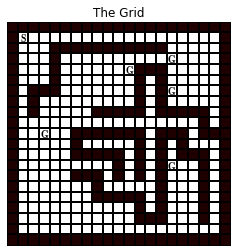

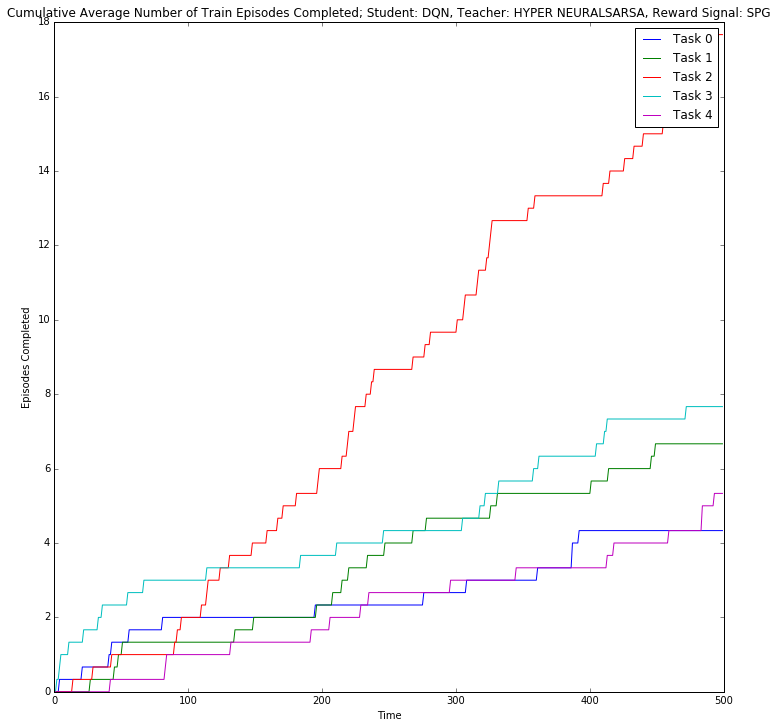

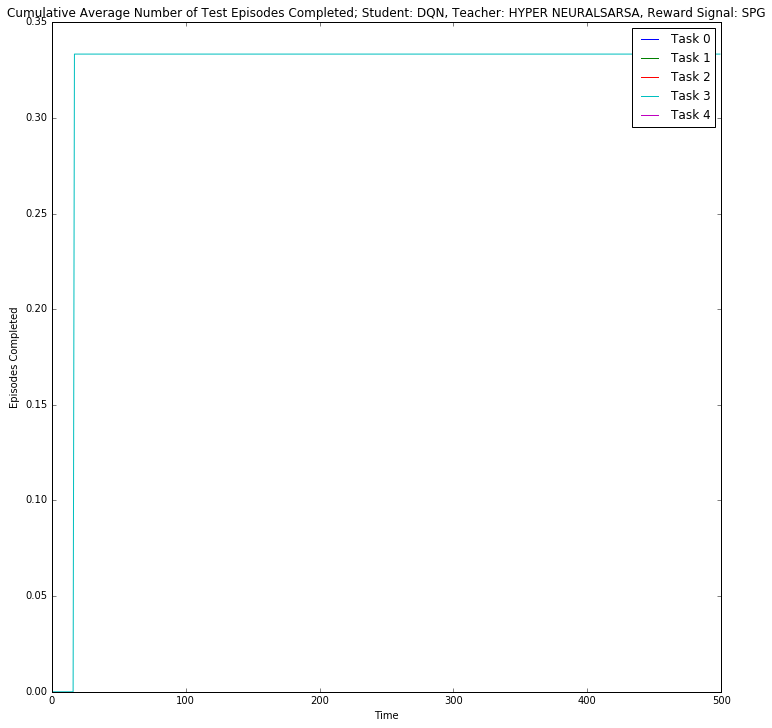

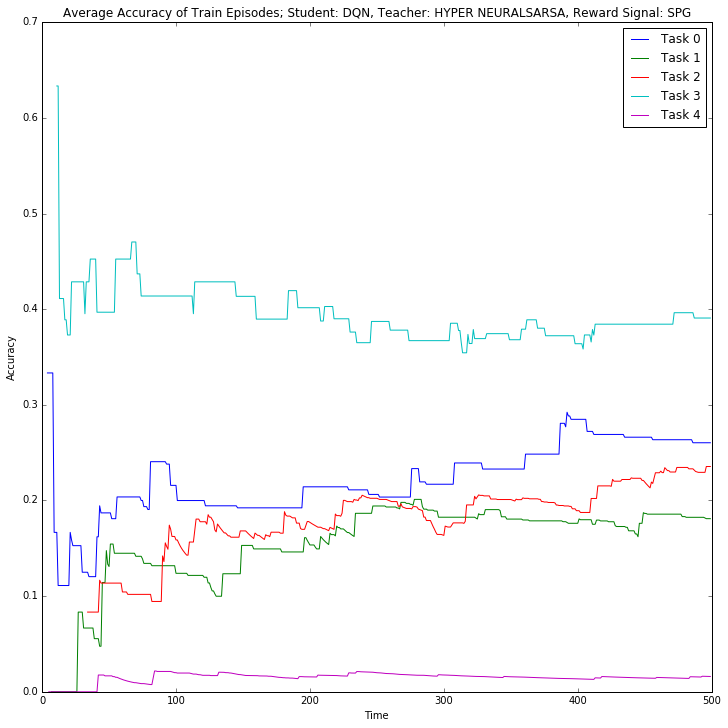

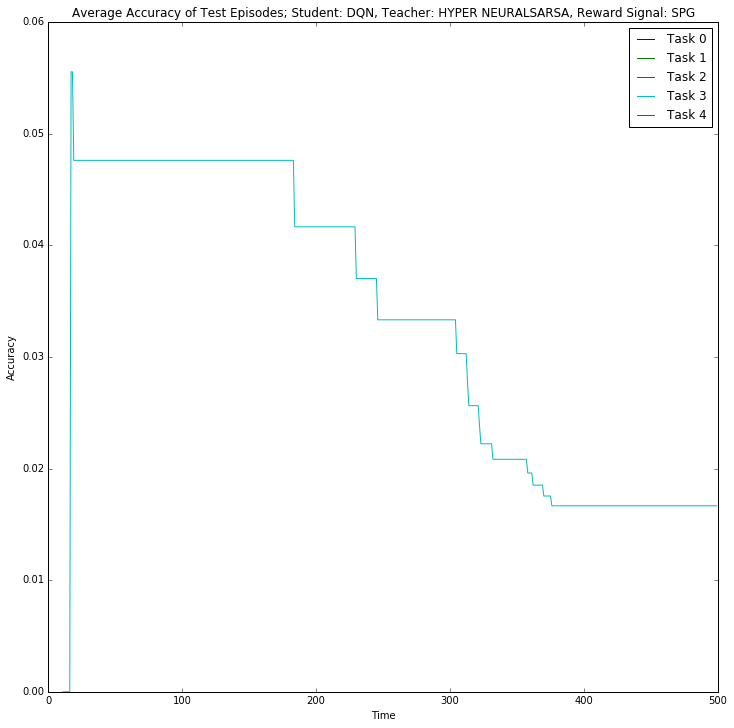

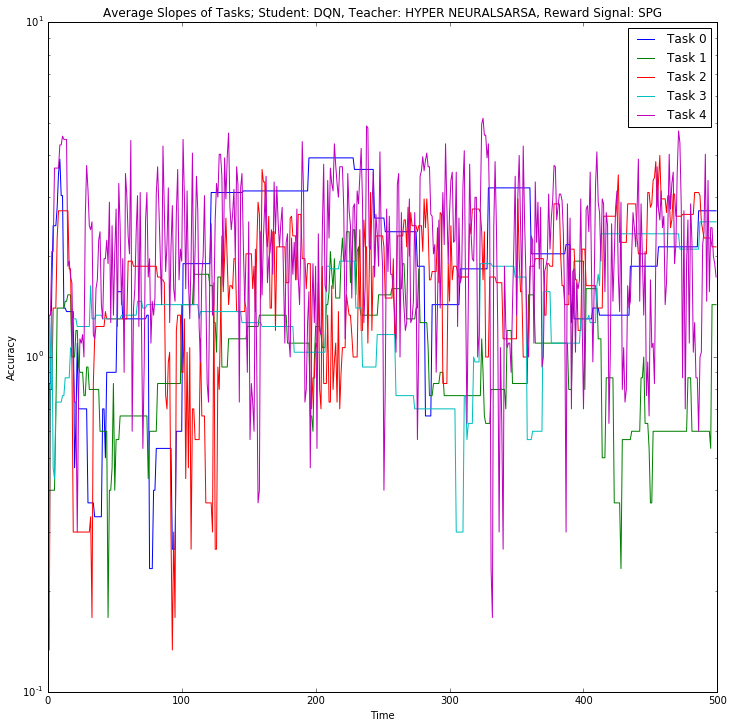

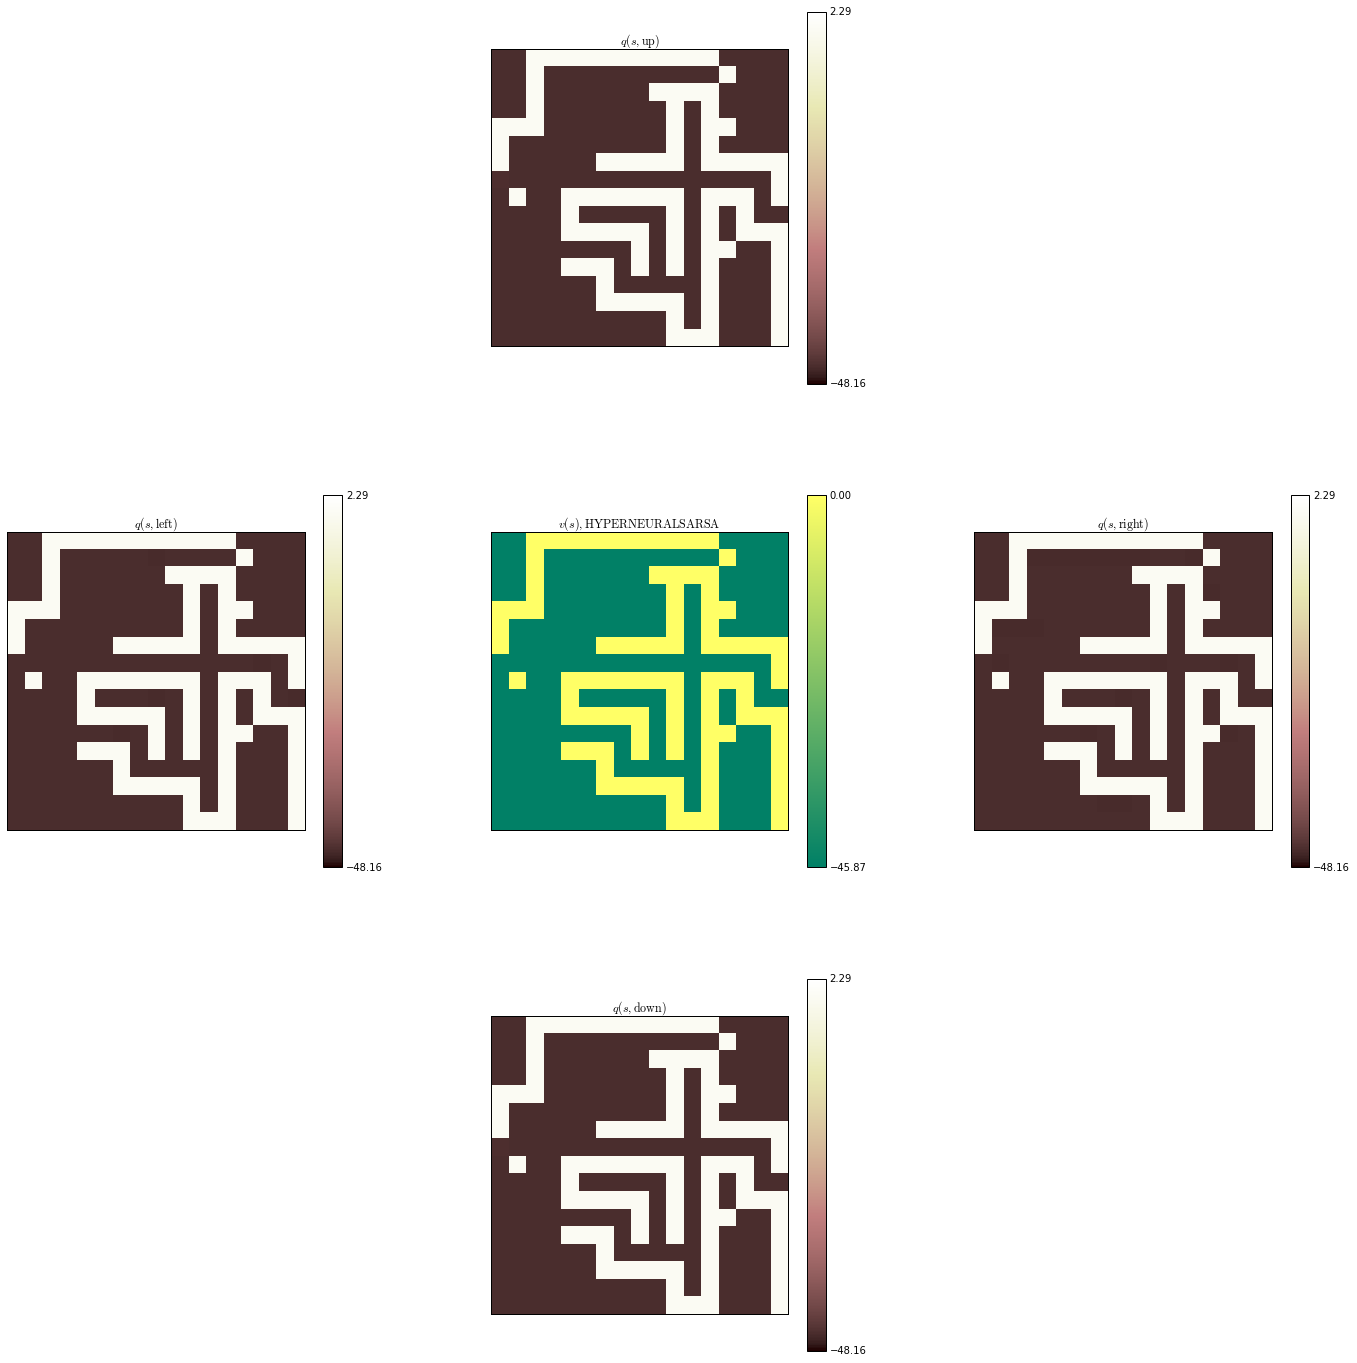

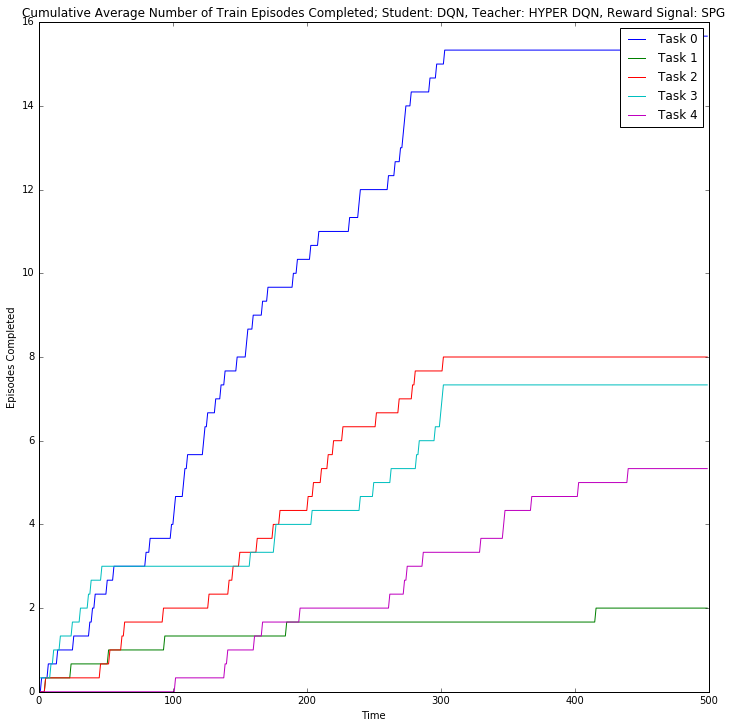

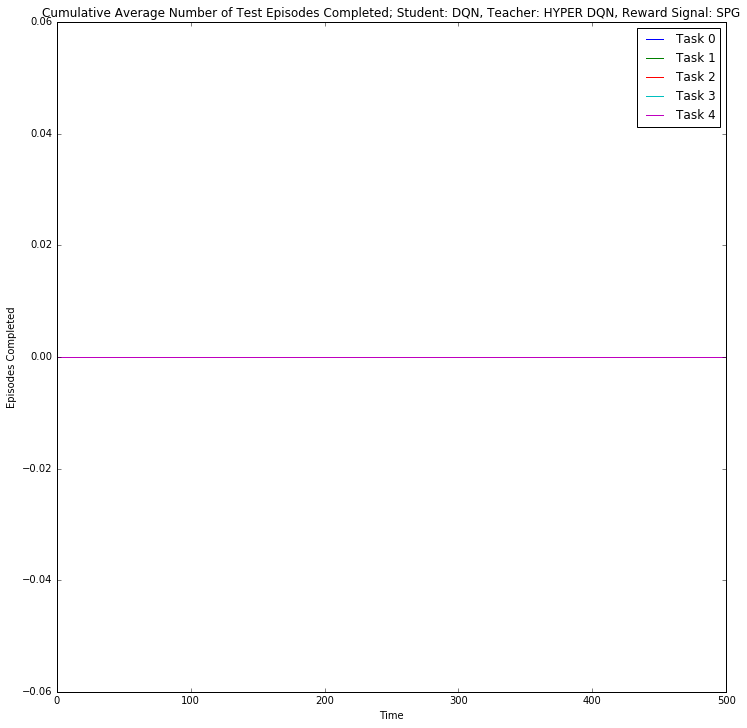

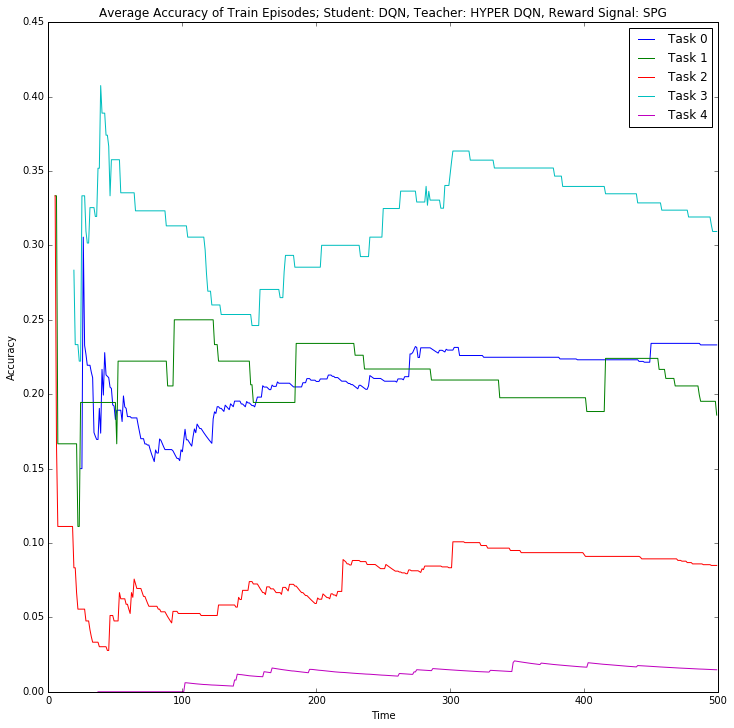

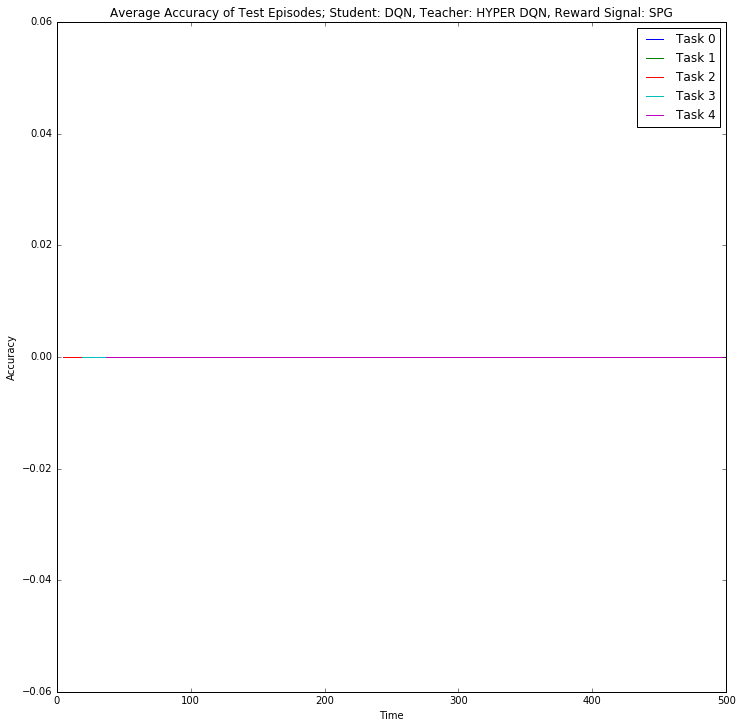

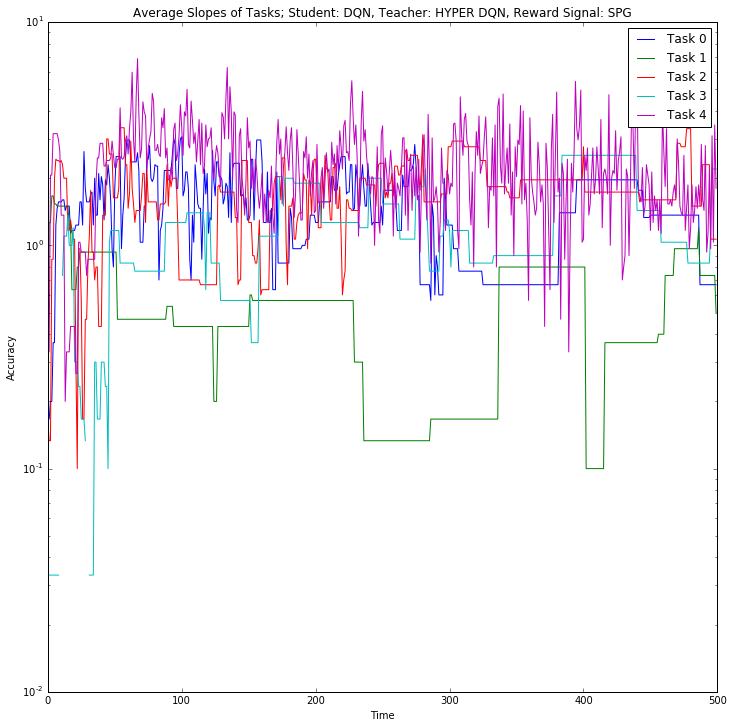

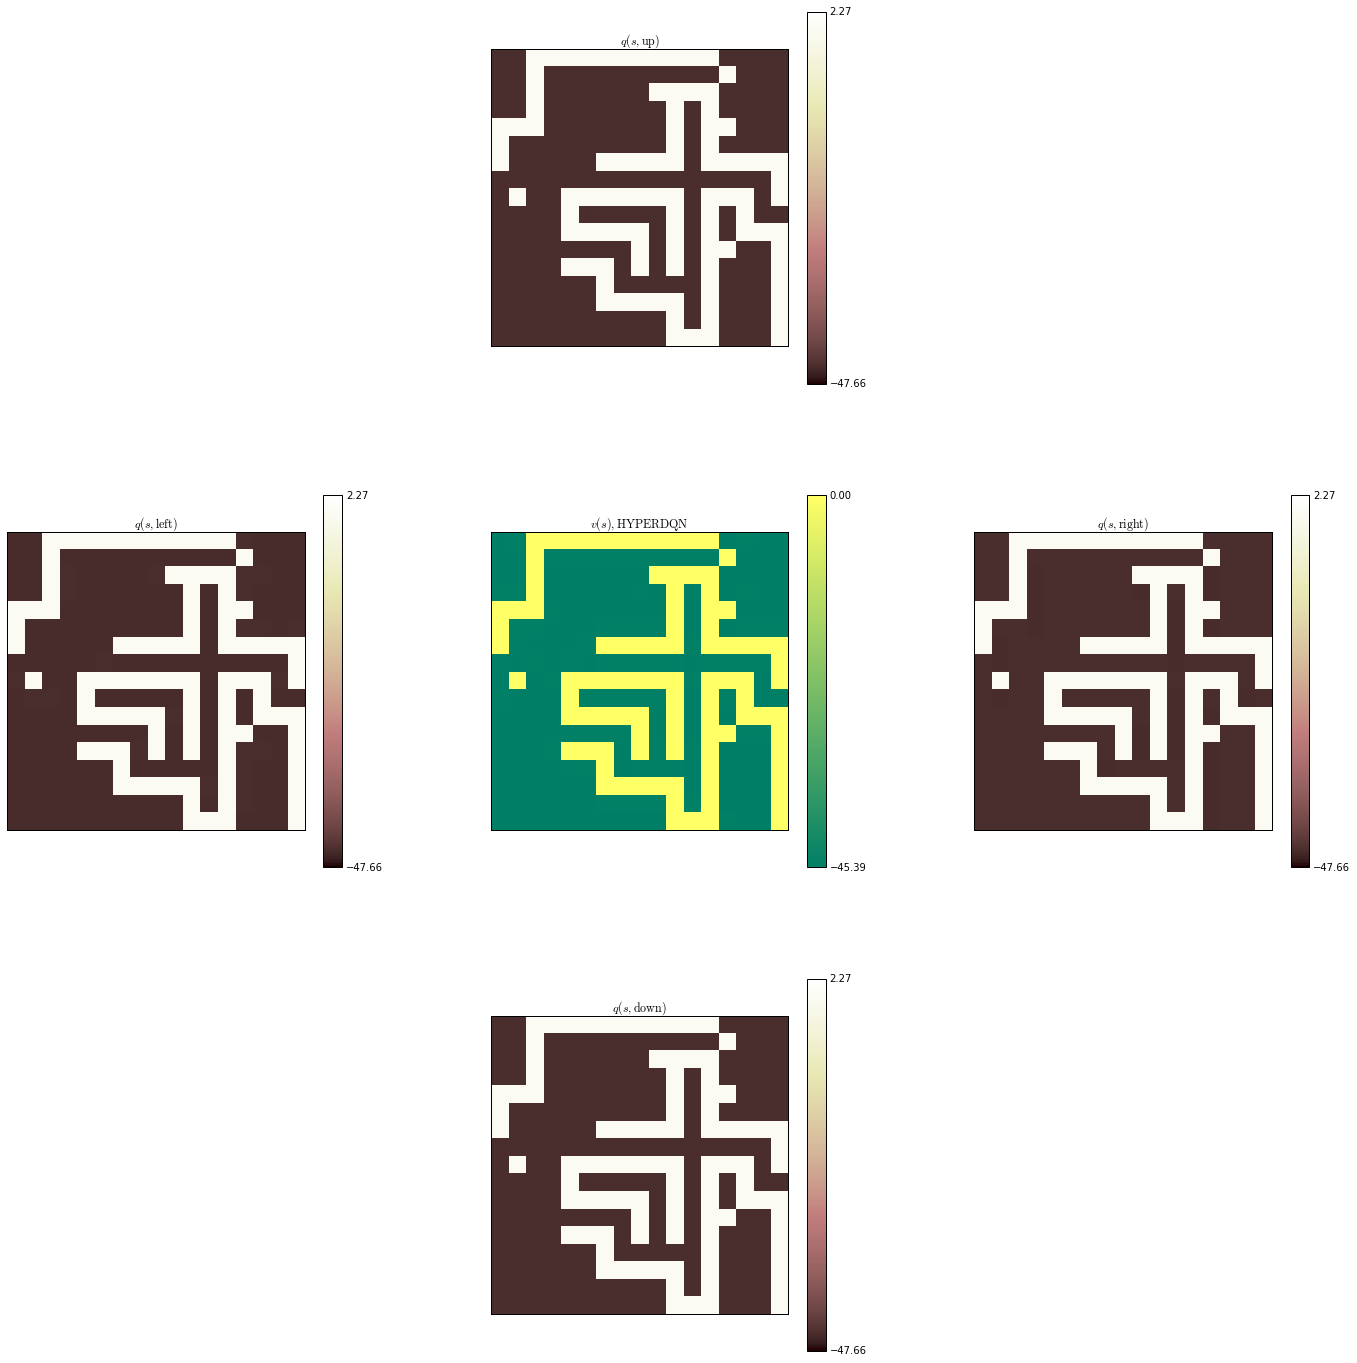

In [301]:
step_size_controller = 0.01
step_size_driver = 0.01

# goal_loc has format (row, col)

for task in tasks:
    task.plot_grid()
    
# Intrinsically Motivated Curriculum Learning
number_of_arms_tasks = len(tasks[0]._goal_loc)


agents = [
    NEURAL_CONTROLLER_DRIVER(number_of_arms_tasks*FIFO_buffer_scores_size,
                              (2*vision_size + 1)**2,
                              hidden_units_controller_net,
                              hidden_units_driver_net,
                              number_of_arms_tasks,
                              4,
                              np.zeros((1,number_of_arms_tasks*FIFO_buffer_scores_size)),
                              tasks[0].get_obs(),
                              'NEURALSARSA',
                              'DQN',
                              num_offline_updates_controller=20, 
                              num_offline_updates_driver=20,
                              step_size_controller=step_size_controller,
                              step_size_driver=step_size_driver),
  NEURAL_CONTROLLER_DRIVER(number_of_arms_tasks*FIFO_buffer_scores_size,
                              (2*vision_size + 1)**2,
                              hidden_units_controller_net,
                              hidden_units_driver_net,
                              number_of_arms_tasks,
                              4,
                              np.zeros((1,number_of_arms_tasks*FIFO_buffer_scores_size)),
                              tasks[0].get_obs(),
                              'DQN',
                              'DQN',
                              num_offline_updates_controller=20, 
                              num_offline_updates_driver=20,
                              step_size_controller=step_size_controller,
                              step_size_driver=step_size_driver),
#   NEURAL_CONTROLLER_DRIVER(number_of_arms_tasks*FIFO_buffer_scores_size,
#                               (2*vision_size + 1)**2,
#                               hidden_units_controller_net,
#                               hidden_units_driver_net,
#                               number_of_arms_tasks,
#                               4,
#                               np.zeros((1,number_of_arms_tasks*FIFO_buffer_scores_size)),
#                               tasks[0].get_obs(),
#                               'DQN',
#                               'NEURALSARSA',
#                               num_offline_updates_controller=25, 
#                               num_offline_updates_driver=25,
#                               step_size_controller=step_size_controller,
#                               step_size_driver=step_size_driver),
#     NEURAL_CONTROLLER_DRIVER(number_of_arms_tasks*FIFO_buffer_scores_size,
#                               (2*vision_size + 1)**2,
#                               hidden_units_controller_net,
#                               hidden_units_driver_net,
#                               number_of_arms_tasks,
#                               4,
#                               np.zeros((1,number_of_arms_tasks*FIFO_buffer_scores_size)),
#                               tasks[0].get_obs(),
#                               'NEURALSARSA',
#                               'NEURALSARSA',
#                               num_offline_updates_controller=25, 
#                               num_offline_updates_driver=25,
#                               step_size_controller=step_size_controller,
#                               step_size_driver=step_size_driver),
    Random(number_of_arms_tasks),
]


for reward_signal in reward_signals:
  train_task_agents(agents,
                    number_of_arms_tasks,
                    number_of_steps_of_selecting_tasks, 
                    tasks,
                    reward_signal,
                    reps,
                    vision_size,
                    tabular_grid,
                    'DQN',
                    hidden_units_driver_net)
        
    
    
    
    